<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-8i1_yu6g
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-8i1_yu6g
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 174 kB 65.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |██████

In [72]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [73]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_conservative import StockTradingEnvCon
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot2 import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [74]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [75]:
# from config.py TRAIN_END_DATE is a string
# config.TRAIN_END_DATE
# df2=TushareDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [76]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [77]:
# print(config_tickers.DOW_30_TICKER)

In [78]:
df=pd.read_csv('./1.csv')
df.shape

(94360, 9)

In [79]:
df.sort_values(['date','tic'],ignore_index=True).head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day
0,0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,1,2008-12-31,57.110001,58.220001,57.060001,43.924454,6287200,AMGN,2
2,2,2008-12-31,17.969999,18.750000,17.910000,14.908465,9625600,AXP,2
3,3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2
4,4,2008-12-31,43.700001,45.099998,43.700001,30.628819,6277400,CAT,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [80]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.INDICATORS,
#                     use_vix=True,
#                     use_turbulence=True,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [81]:
# list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

# processed_full = processed_full.fillna(0)

In [82]:
processed_full=pd.read_csv('./2.csv')
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.606277,607541200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,2.606277,2.606277,40.0,0.0
1,1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.924454,6287200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.924454,43.924454,40.0,0.0
2,2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.908465,9625600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,14.908465,14.908465,40.0,0.0
3,3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005894,5443100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,32.005894,32.005894,40.0,0.0
4,4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.628819,6277400.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,30.628819,30.628819,40.0,0.0
5,5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.787783,37513700.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,11.787783,11.787783,40.0,0.0
7,7,2008-12-31,CVX,72.900002,74.629997,72.900002,43.314438,9964300.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.314438,43.314438,40.0,0.0
8,8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538342,9012100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,19.538342,19.538342,40.0,0.0
9,9,2008-12-31,GS,82.239998,86.150002,81.120003,69.224182,14894100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,69.224182,69.224182,40.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [83]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [84]:
train.tail()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,121795,2020-06-30,UNH,288.570007,296.450012,287.660004,287.776794,2932900.0,1.0,-0.019475,303.925869,271.251255,52.413046,-25.838431,1.846804,288.020689,281.001438,30.43,12.918751
2892,121796,2020-06-30,V,191.490005,193.750000,190.160004,190.737244,9040100.0,1.0,1.048786,198.750528,185.041391,53.021033,-51.550760,2.013358,191.485037,181.677683,30.43,12.918751
2892,121797,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376743,17414800.0,1.0,-0.437111,53.918425,48.729324,48.097044,-51.018262,8.508886,51.012123,51.464679,30.43,12.918751
2892,121798,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035732,4782100.0,1.0,-0.083986,42.609305,36.487095,48.830181,-14.508130,1.500723,39.135190,38.935129,30.43,12.918751
2892,121799,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121765,6836400.0,1.0,-0.886569,119.473758,113.510454,48.159665,-69.938795,3.847271,117.787627,119.723273,30.43,12.918751


In [85]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [86]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [87]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [88]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

e_train_gym_conservative = StockTradingEnvCon(df = train, **env_kwargs)
e_train_gym_conservative.value_history.shape

(20,)

## Environment for Training



In [89]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train_con, _ = e_train_gym_conservative.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [90]:
agent = DRLAgent(env = env_train)
agent_con = DRLAgent(env = env_train_con)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [33]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}


KeyboardInterrupt: 

In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [19]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [30]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name="1",
                             total_timesteps=3000000)

Logging to ppo/1_1
----------------------------------
| time/              |           |
|    fps             | 124       |
|    iterations      | 1         |
|    time_elapsed    | 16        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5073655 |
----------------------------------
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3946387.70
total_reward: 2946387.70
total_cost: 357438.48
total_trades: 81024
Sharpe: 0.793
-----------------------------------------
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 2           |
|    time_elapsed         | 34          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015788507 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00723     |


KeyboardInterrupt: 

### Model 4: TD3

In [91]:
agent_con = DRLAgent(env = env_train_con)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo2 = agent_con.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [92]:
# model_ppo2.load('42')
print('load')
trained_ppo2 = agent_con.train_model(model=model_ppo2, 
                             tb_log_name="7",
                             total_timesteps=6000000)

load
Logging to ppo/7_6
-----------------------------------
| time/              |            |
|    fps             | 112        |
|    iterations      | 1          |
|    time_elapsed    | 18         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.34528866 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2           |
|    time_elapsed         | 36          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011976912 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.0235      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.18        |
|    n_updates            | 10          |
|    policy_gradient_l

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 12          |
|    time_elapsed         | 226         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.018881794 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.4       |
|    explained_variance   | -0.00268    |
|    learning_rate        | 0.00025     |
|    loss                 | 14.1        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0119     |
|    reward               | 0.21985316  |
|    std                  | 1.01        |
|    value_loss           | 34.9        |
-----------------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 5079946.36
total_reward: 4079946.36
total_cost: 334610.25
total_trades: 79408
Sharpe: 0.87

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 22          |
|    time_elapsed         | 414         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.017376442 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.9       |
|    explained_variance   | 0.0175      |
|    learning_rate        | 0.00025     |
|    loss                 | 30.7        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0113     |
|    reward               | 2.63466     |
|    std                  | 1.03        |
|    value_loss           | 45.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 23    

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 32          |
|    time_elapsed         | 602         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.023171712 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.2       |
|    explained_variance   | 0.00492     |
|    learning_rate        | 0.00025     |
|    loss                 | 28.9        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.013      |
|    reward               | 0.19132055  |
|    std                  | 1.04        |
|    value_loss           | 54.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 33 

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 42          |
|    time_elapsed         | 790         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.021502744 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43         |
|    explained_variance   | 0.0279      |
|    learning_rate        | 0.00025     |
|    loss                 | 23.7        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00641    |
|    reward               | 0.39835757  |
|    std                  | 1.07        |
|    value_loss           | 62.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 43    

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 52          |
|    time_elapsed         | 978         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.033833615 |
|    clip_fraction        | 0.323       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.4       |
|    explained_variance   | 0.0297      |
|    learning_rate        | 0.00025     |
|    loss                 | 29.8        |
|    n_updates            | 510         |
|    policy_gradient_loss | 0.00119     |
|    reward               | -4.975218   |
|    std                  | 1.08        |
|    value_loss           | 50.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 53    

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 62          |
|    time_elapsed         | 1167        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.038821533 |
|    clip_fraction        | 0.326       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.9       |
|    explained_variance   | 0.0118      |
|    learning_rate        | 0.00025     |
|    loss                 | 43.7        |
|    n_updates            | 610         |
|    policy_gradient_loss | 0.00397     |
|    reward               | 2.6262228   |
|    std                  | 1.1         |
|    value_loss           | 131         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 63    

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 72          |
|    time_elapsed         | 1355        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.022447813 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.0162      |
|    learning_rate        | 0.00025     |
|    loss                 | 48.4        |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.0036     |
|    reward               | -32.370094  |
|    std                  | 1.12        |
|    value_loss           | 140         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 73    

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 82          |
|    time_elapsed         | 1544        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.022878919 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45         |
|    explained_variance   | 0.00842     |
|    learning_rate        | 0.00025     |
|    loss                 | 27.1        |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.0119     |
|    reward               | -0.41385123 |
|    std                  | 1.14        |
|    value_loss           | 117         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 83    

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 92         |
|    time_elapsed         | 1731       |
|    total_timesteps      | 188416     |
| train/                  |            |
|    approx_kl            | 0.03327501 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -45.6      |
|    explained_variance   | -0.0116    |
|    learning_rate        | 0.00025    |
|    loss                 | 81.1       |
|    n_updates            | 910        |
|    policy_gradient_loss | -0.00241   |
|    reward               | -1.9355103 |
|    std                  | 1.17       |
|    value_loss           | 147        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 93          |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 102         |
|    time_elapsed         | 1918        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.049330335 |
|    clip_fraction        | 0.406       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46         |
|    explained_variance   | 0.035       |
|    learning_rate        | 0.00025     |
|    loss                 | 27.8        |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.00804    |
|    reward               | -1.9726336  |
|    std                  | 1.18        |
|    value_loss           | 66.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 103   

day: 2892, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 5319540.86
total_reward: 4319540.86
total_cost: 267199.62
total_trades: 71192
Sharpe: 0.844
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 112         |
|    time_elapsed         | 2106        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.024499629 |
|    clip_fraction        | 0.258       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.6       |
|    explained_variance   | 0.00876     |
|    learning_rate        | 0.00025     |
|    loss                 | 75          |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.0106     |
|    reward               | -1.3410271  |
|    std                  | 1.21        |
|    value_loss           | 157         |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 122         |
|    time_elapsed         | 2295        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.044485092 |
|    clip_fraction        | 0.37        |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.2       |
|    explained_variance   | 0.00885     |
|    learning_rate        | 0.00025     |
|    loss                 | 103         |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.00844    |
|    reward               | 0.1264349   |
|    std                  | 1.23        |
|    value_loss           | 81          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 123   

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 132        |
|    time_elapsed         | 2485       |
|    total_timesteps      | 270336     |
| train/                  |            |
|    approx_kl            | 0.04329545 |
|    clip_fraction        | 0.389      |
|    clip_range           | 0.2        |
|    entropy_loss         | -47.9      |
|    explained_variance   | 0.046      |
|    learning_rate        | 0.00025    |
|    loss                 | 5.98       |
|    n_updates            | 1310       |
|    policy_gradient_loss | -0.0134    |
|    reward               | 0.21224125 |
|    std                  | 1.27       |
|    value_loss           | 13.5       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 133        |
|    time_elapse

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 142         |
|    time_elapsed         | 2673        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.031456165 |
|    clip_fraction        | 0.284       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.4       |
|    explained_variance   | -0.0793     |
|    learning_rate        | 0.00025     |
|    loss                 | 15.3        |
|    n_updates            | 1410        |
|    policy_gradient_loss | -0.00423    |
|    reward               | -1.4980985  |
|    std                  | 1.28        |
|    value_loss           | 31.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 143   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 152         |
|    time_elapsed         | 2860        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.032924388 |
|    clip_fraction        | 0.334       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.8       |
|    explained_variance   | -0.0841     |
|    learning_rate        | 0.00025     |
|    loss                 | 18          |
|    n_updates            | 1510        |
|    policy_gradient_loss | -0.000426   |
|    reward               | -2.1959875  |
|    std                  | 1.3         |
|    value_loss           | 34.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 153   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 162         |
|    time_elapsed         | 3048        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.033363655 |
|    clip_fraction        | 0.252       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.3       |
|    explained_variance   | -0.0185     |
|    learning_rate        | 0.00025     |
|    loss                 | 118         |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.00298    |
|    reward               | -1.2411642  |
|    std                  | 1.33        |
|    value_loss           | 179         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 163   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 172         |
|    time_elapsed         | 3235        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.035065174 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.7       |
|    explained_variance   | 0.00551     |
|    learning_rate        | 0.00025     |
|    loss                 | 115         |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.00355    |
|    reward               | 0.8538932   |
|    std                  | 1.34        |
|    value_loss           | 323         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 173   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 182         |
|    time_elapsed         | 3424        |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.017370392 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.1       |
|    explained_variance   | 0.0107      |
|    learning_rate        | 0.00025     |
|    loss                 | 176         |
|    n_updates            | 1810        |
|    policy_gradient_loss | -0.00558    |
|    reward               | -4.577925   |
|    std                  | 1.37        |
|    value_loss           | 335         |
-----------------------------------------
day: 2892, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 5410776.57
total_reward: 4410776.57
total_cost: 303012.22
total_trades: 72796
Sharpe: 0.8

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 192         |
|    time_elapsed         | 3629        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.023890898 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.7       |
|    explained_variance   | 0.0164      |
|    learning_rate        | 0.00025     |
|    loss                 | 60.1        |
|    n_updates            | 1910        |
|    policy_gradient_loss | -0.00377    |
|    reward               | -7.3574524  |
|    std                  | 1.4         |
|    value_loss           | 296         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 193   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 202         |
|    time_elapsed         | 3818        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.032261774 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.2       |
|    explained_variance   | 0.0438      |
|    learning_rate        | 0.00025     |
|    loss                 | 64.9        |
|    n_updates            | 2010        |
|    policy_gradient_loss | 0.00223     |
|    reward               | -16.247347  |
|    std                  | 1.42        |
|    value_loss           | 172         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 203   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 212         |
|    time_elapsed         | 4006        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.02944604  |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.6       |
|    explained_variance   | 0.046       |
|    learning_rate        | 0.00025     |
|    loss                 | 209         |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.00774    |
|    reward               | -0.23749915 |
|    std                  | 1.44        |
|    value_loss           | 212         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 213   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 222         |
|    time_elapsed         | 4195        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.039265454 |
|    clip_fraction        | 0.351       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.2       |
|    explained_variance   | 0.138       |
|    learning_rate        | 0.00025     |
|    loss                 | 67.9        |
|    n_updates            | 2210        |
|    policy_gradient_loss | -0.00932    |
|    reward               | 0.09672117  |
|    std                  | 1.47        |
|    value_loss           | 250         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 223      

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 232         |
|    time_elapsed         | 4386        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.03985005  |
|    clip_fraction        | 0.337       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.7       |
|    explained_variance   | 0.226       |
|    learning_rate        | 0.00025     |
|    loss                 | 28.6        |
|    n_updates            | 2310        |
|    policy_gradient_loss | -0.00823    |
|    reward               | -0.49090016 |
|    std                  | 1.5         |
|    value_loss           | 111         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 233      

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 242        |
|    time_elapsed         | 4573       |
|    total_timesteps      | 495616     |
| train/                  |            |
|    approx_kl            | 0.02473622 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -53.2      |
|    explained_variance   | 0.166      |
|    learning_rate        | 0.00025    |
|    loss                 | 90.5       |
|    n_updates            | 2410       |
|    policy_gradient_loss | -0.00633   |
|    reward               | 1.0851558  |
|    std                  | 1.52       |
|    value_loss           | 152        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 243         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 252        |
|    time_elapsed         | 4762       |
|    total_timesteps      | 516096     |
| train/                  |            |
|    approx_kl            | 0.03305272 |
|    clip_fraction        | 0.318      |
|    clip_range           | 0.2        |
|    entropy_loss         | -53.8      |
|    explained_variance   | 0.21       |
|    learning_rate        | 0.00025    |
|    loss                 | 19.3       |
|    n_updates            | 2510       |
|    policy_gradient_loss | -0.00875   |
|    reward               | 1.210551   |
|    std                  | 1.56       |
|    value_loss           | 39.9       |
----------------------------------------
day: 2892, episode: 180
begin_total_asset: 1000000.00
end_total_asset: 2887196.68
total_reward: 1887196.68
total_cost: 315389.47
total_trades: 72444
Sharpe: 0.546
-----------------

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 262        |
|    time_elapsed         | 4951       |
|    total_timesteps      | 536576     |
| train/                  |            |
|    approx_kl            | 0.03259542 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -54.4      |
|    explained_variance   | 0.123      |
|    learning_rate        | 0.00025    |
|    loss                 | 7.42       |
|    n_updates            | 2610       |
|    policy_gradient_loss | -0.00603   |
|    reward               | -0.3207658 |
|    std                  | 1.58       |
|    value_loss           | 20.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 263         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 272        |
|    time_elapsed         | 5139       |
|    total_timesteps      | 557056     |
| train/                  |            |
|    approx_kl            | 0.03563013 |
|    clip_fraction        | 0.335      |
|    clip_range           | 0.2        |
|    entropy_loss         | -55        |
|    explained_variance   | -0.0371    |
|    learning_rate        | 0.00025    |
|    loss                 | 19.1       |
|    n_updates            | 2710       |
|    policy_gradient_loss | -0.00984   |
|    reward               | 2.1662436  |
|    std                  | 1.62       |
|    value_loss           | 35.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 273         |
|    time_el

day: 2892, episode: 200
begin_total_asset: 1000000.00
end_total_asset: 3831150.38
total_reward: 2831150.38
total_cost: 302401.21
total_trades: 70575
Sharpe: 0.699
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 282         |
|    time_elapsed         | 5332        |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.037174877 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.5       |
|    explained_variance   | 0.0164      |
|    learning_rate        | 0.00025     |
|    loss                 | 25.7        |
|    n_updates            | 2810        |
|    policy_gradient_loss | -0.0125     |
|    reward               | -0.3771052  |
|    std                  | 1.65        |
|    value_loss           | 48.3        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 292         |
|    time_elapsed         | 5522        |
|    total_timesteps      | 598016      |
| train/                  |             |
|    approx_kl            | 0.021964226 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.3       |
|    explained_variance   | 0.0575      |
|    learning_rate        | 0.00025     |
|    loss                 | 55.9        |
|    n_updates            | 2910        |
|    policy_gradient_loss | -0.00678    |
|    reward               | -0.42943832 |
|    std                  | 1.69        |
|    value_loss           | 159         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 293   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 302         |
|    time_elapsed         | 5712        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.017200906 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.8       |
|    explained_variance   | 0.151       |
|    learning_rate        | 0.00025     |
|    loss                 | 89.6        |
|    n_updates            | 3010        |
|    policy_gradient_loss | -0.00308    |
|    reward               | -8.15209    |
|    std                  | 1.72        |
|    value_loss           | 146         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 303      

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 312         |
|    time_elapsed         | 5900        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.030223217 |
|    clip_fraction        | 0.291       |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.6       |
|    explained_variance   | 0.0171      |
|    learning_rate        | 0.00025     |
|    loss                 | 22.2        |
|    n_updates            | 3110        |
|    policy_gradient_loss | -0.00519    |
|    reward               | 1.7298117   |
|    std                  | 1.77        |
|    value_loss           | 115         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 313   

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 322        |
|    time_elapsed         | 6090       |
|    total_timesteps      | 659456     |
| train/                  |            |
|    approx_kl            | 0.03186138 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -58.2      |
|    explained_variance   | 0.0418     |
|    learning_rate        | 0.00025    |
|    loss                 | 84.3       |
|    n_updates            | 3210       |
|    policy_gradient_loss | -0.00327   |
|    reward               | 2.907804   |
|    std                  | 1.81       |
|    value_loss           | 245        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 323         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 332         |
|    time_elapsed         | 6278        |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.026013914 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.8       |
|    explained_variance   | 0.116       |
|    learning_rate        | 0.00025     |
|    loss                 | 35.2        |
|    n_updates            | 3310        |
|    policy_gradient_loss | 0.00104     |
|    reward               | -0.2609371  |
|    std                  | 1.85        |
|    value_loss           | 164         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 333      

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 342         |
|    time_elapsed         | 6469        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.016048629 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.6       |
|    explained_variance   | 0.00644     |
|    learning_rate        | 0.00025     |
|    loss                 | 28.4        |
|    n_updates            | 3410        |
|    policy_gradient_loss | -0.00927    |
|    reward               | 0.04062053  |
|    std                  | 1.9         |
|    value_loss           | 200         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 343   

day: 2892, episode: 250
begin_total_asset: 1000000.00
end_total_asset: 2952630.86
total_reward: 1952630.86
total_cost: 295427.25
total_trades: 68094
Sharpe: 0.547
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 352        |
|    time_elapsed         | 6656       |
|    total_timesteps      | 720896     |
| train/                  |            |
|    approx_kl            | 0.02821625 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -60.1      |
|    explained_variance   | 3.29e-05   |
|    learning_rate        | 0.00025    |
|    loss                 | 255        |
|    n_updates            | 3510       |
|    policy_gradient_loss | -0.00868   |
|    reward               | -0.8892708 |
|    std                  | 1.93       |
|    value_loss           | 226        |
----------------------------------------
-----------------

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 362        |
|    time_elapsed         | 6844       |
|    total_timesteps      | 741376     |
| train/                  |            |
|    approx_kl            | 0.01619699 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -60.6      |
|    explained_variance   | 0.0979     |
|    learning_rate        | 0.00025    |
|    loss                 | 124        |
|    n_updates            | 3610       |
|    policy_gradient_loss | -0.0122    |
|    reward               | 0.8918226  |
|    std                  | 1.97       |
|    value_loss           | 122        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 363         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 372        |
|    time_elapsed         | 7032       |
|    total_timesteps      | 761856     |
| train/                  |            |
|    approx_kl            | 0.02305965 |
|    clip_fraction        | 0.196      |
|    clip_range           | 0.2        |
|    entropy_loss         | -61.1      |
|    explained_variance   | 0.00243    |
|    learning_rate        | 0.00025    |
|    loss                 | 80.5       |
|    n_updates            | 3710       |
|    policy_gradient_loss | -0.011     |
|    reward               | 1.130414   |
|    std                  | 2          |
|    value_loss           | 141        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 373         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 382         |
|    time_elapsed         | 7219        |
|    total_timesteps      | 782336      |
| train/                  |             |
|    approx_kl            | 0.026974216 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.6       |
|    explained_variance   | 0.141       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.8        |
|    n_updates            | 3810        |
|    policy_gradient_loss | -0.0137     |
|    reward               | 1.1600329   |
|    std                  | 2.04        |
|    value_loss           | 27.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 383   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 392         |
|    time_elapsed         | 7410        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.0328981   |
|    clip_fraction        | 0.288       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.4       |
|    explained_variance   | -0.0188     |
|    learning_rate        | 0.00025     |
|    loss                 | 13.8        |
|    n_updates            | 3910        |
|    policy_gradient_loss | -0.00767    |
|    reward               | -0.56017286 |
|    std                  | 2.09        |
|    value_loss           | 26.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 393   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 402         |
|    time_elapsed         | 7597        |
|    total_timesteps      | 823296      |
| train/                  |             |
|    approx_kl            | 0.033208806 |
|    clip_fraction        | 0.322       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63         |
|    explained_variance   | -0.0256     |
|    learning_rate        | 0.00025     |
|    loss                 | 21.3        |
|    n_updates            | 4010        |
|    policy_gradient_loss | -0.0115     |
|    reward               | 0.65962577  |
|    std                  | 2.13        |
|    value_loss           | 40.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 403   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 412         |
|    time_elapsed         | 7787        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.03060722  |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.6       |
|    explained_variance   | -0.012      |
|    learning_rate        | 0.00025     |
|    loss                 | 18          |
|    n_updates            | 4110        |
|    policy_gradient_loss | -0.00787    |
|    reward               | -0.15844512 |
|    std                  | 2.19        |
|    value_loss           | 37.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 413   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 422         |
|    time_elapsed         | 7978        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.025893793 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.2       |
|    explained_variance   | 0.0062      |
|    learning_rate        | 0.00025     |
|    loss                 | 80.3        |
|    n_updates            | 4210        |
|    policy_gradient_loss | 0.000245    |
|    reward               | 1.7965183   |
|    std                  | 2.23        |
|    value_loss           | 257         |
-----------------------------------------
day: 2892, episode: 300
begin_total_asset: 1000000.00
end_total_asset: 5577826.92
total_reward: 4577826.92
total_cost: 244089.21
total_trades: 64434
Sharpe: 0.9

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 432         |
|    time_elapsed         | 8168        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.023945741 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.9       |
|    explained_variance   | 0.0464      |
|    learning_rate        | 0.00025     |
|    loss                 | 26.2        |
|    n_updates            | 4310        |
|    policy_gradient_loss | -0.0104     |
|    reward               | -0.5040143  |
|    std                  | 2.28        |
|    value_loss           | 65.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 433   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 442         |
|    time_elapsed         | 8356        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.016234905 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.3       |
|    explained_variance   | 0.161       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.6        |
|    n_updates            | 4410        |
|    policy_gradient_loss | -0.0014     |
|    reward               | 1.1054587   |
|    std                  | 2.32        |
|    value_loss           | 46.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 443   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 452         |
|    time_elapsed         | 8548        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.025339955 |
|    clip_fraction        | 0.284       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.6       |
|    explained_variance   | 0.179       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.3        |
|    n_updates            | 4510        |
|    policy_gradient_loss | -0.00741    |
|    reward               | -4.9024944  |
|    std                  | 2.34        |
|    value_loss           | 60.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 453   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 462         |
|    time_elapsed         | 8740        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.040018555 |
|    clip_fraction        | 0.312       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66         |
|    explained_variance   | 0.0104      |
|    learning_rate        | 0.00025     |
|    loss                 | 14.2        |
|    n_updates            | 4610        |
|    policy_gradient_loss | -0.00783    |
|    reward               | -0.73713845 |
|    std                  | 2.37        |
|    value_loss           | 47.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 463   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 472         |
|    time_elapsed         | 8931        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.027818378 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67         |
|    explained_variance   | 0.00487     |
|    learning_rate        | 0.00025     |
|    loss                 | 68.6        |
|    n_updates            | 4710        |
|    policy_gradient_loss | -0.00572    |
|    reward               | -0.66765314 |
|    std                  | 2.46        |
|    value_loss           | 135         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 473   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 482         |
|    time_elapsed         | 9121        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.023299035 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.9       |
|    explained_variance   | 0.00901     |
|    learning_rate        | 0.00025     |
|    loss                 | 73.1        |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.0129     |
|    reward               | -0.43828452 |
|    std                  | 2.53        |
|    value_loss           | 71          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 483   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 492         |
|    time_elapsed         | 9308        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.014473364 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.4       |
|    explained_variance   | 0.0354      |
|    learning_rate        | 0.00025     |
|    loss                 | 138         |
|    n_updates            | 4910        |
|    policy_gradient_loss | -0.0119     |
|    reward               | 2.2716284   |
|    std                  | 2.58        |
|    value_loss           | 226         |
-----------------------------------------
day: 2892, episode: 350
begin_total_asset: 1000000.00
end_total_asset: 5954812.29
total_reward: 4954812.29
total_cost: 322233.70
total_trades: 69872
Sharpe: 0.9

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 502        |
|    time_elapsed         | 9496       |
|    total_timesteps      | 1028096    |
| train/                  |            |
|    approx_kl            | 0.02329624 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -68.8      |
|    explained_variance   | 0.0395     |
|    learning_rate        | 0.00025    |
|    loss                 | 117        |
|    n_updates            | 5010       |
|    policy_gradient_loss | -0.0124    |
|    reward               | -0.178321  |
|    std                  | 2.61       |
|    value_loss           | 172        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 503         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 512        |
|    time_elapsed         | 9687       |
|    total_timesteps      | 1048576    |
| train/                  |            |
|    approx_kl            | 0.03428732 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -69.4      |
|    explained_variance   | -0.108     |
|    learning_rate        | 0.00025    |
|    loss                 | 8.56       |
|    n_updates            | 5110       |
|    policy_gradient_loss | -0.00768   |
|    reward               | -1.9333843 |
|    std                  | 2.66       |
|    value_loss           | 23.9       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 513        |
|    time_elapse

day: 2892, episode: 370
begin_total_asset: 1000000.00
end_total_asset: 2736016.65
total_reward: 1736016.65
total_cost: 349142.45
total_trades: 69226
Sharpe: 0.560
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 522         |
|    time_elapsed         | 9874        |
|    total_timesteps      | 1069056     |
| train/                  |             |
|    approx_kl            | 0.028467271 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.9       |
|    explained_variance   | -0.266      |
|    learning_rate        | 0.00025     |
|    loss                 | 8.36        |
|    n_updates            | 5210        |
|    policy_gradient_loss | -0.00168    |
|    reward               | 0.16497122  |
|    std                  | 2.72        |
|    value_loss           | 20.1        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 532         |
|    time_elapsed         | 10063       |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.025475748 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.5       |
|    explained_variance   | 0.169       |
|    learning_rate        | 0.00025     |
|    loss                 | 23.1        |
|    n_updates            | 5310        |
|    policy_gradient_loss | -0.00797    |
|    reward               | 0.4748754   |
|    std                  | 2.77        |
|    value_loss           | 34.6        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 533      

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 542        |
|    time_elapsed         | 10255      |
|    total_timesteps      | 1110016    |
| train/                  |            |
|    approx_kl            | 0.02203055 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -71        |
|    explained_variance   | 0.0174     |
|    learning_rate        | 0.00025    |
|    loss                 | 222        |
|    n_updates            | 5410       |
|    policy_gradient_loss | -0.0104    |
|    reward               | 4.2842474  |
|    std                  | 2.81       |
|    value_loss           | 176        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 543         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 552        |
|    time_elapsed         | 10442      |
|    total_timesteps      | 1130496    |
| train/                  |            |
|    approx_kl            | 0.01918323 |
|    clip_fraction        | 0.196      |
|    clip_range           | 0.2        |
|    entropy_loss         | -71.6      |
|    explained_variance   | -0.0122    |
|    learning_rate        | 0.00025    |
|    loss                 | 126        |
|    n_updates            | 5510       |
|    policy_gradient_loss | -0.011     |
|    reward               | -1.3963896 |
|    std                  | 2.88       |
|    value_loss           | 180        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 553         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 562         |
|    time_elapsed         | 10630       |
|    total_timesteps      | 1150976     |
| train/                  |             |
|    approx_kl            | 0.012573689 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.2       |
|    explained_variance   | 0.0617      |
|    learning_rate        | 0.00025     |
|    loss                 | 82.8        |
|    n_updates            | 5610        |
|    policy_gradient_loss | -0.0118     |
|    reward               | 8.990063    |
|    std                  | 2.93        |
|    value_loss           | 182         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 563   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 572         |
|    time_elapsed         | 10822       |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.016100012 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.5       |
|    explained_variance   | 0.137       |
|    learning_rate        | 0.00025     |
|    loss                 | 65.8        |
|    n_updates            | 5710        |
|    policy_gradient_loss | -0.0111     |
|    reward               | -3.2848046  |
|    std                  | 2.97        |
|    value_loss           | 102         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 573   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 582         |
|    time_elapsed         | 11011       |
|    total_timesteps      | 1191936     |
| train/                  |             |
|    approx_kl            | 0.025342377 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.1       |
|    explained_variance   | 0.0334      |
|    learning_rate        | 0.00025     |
|    loss                 | 35.7        |
|    n_updates            | 5810        |
|    policy_gradient_loss | -0.0106     |
|    reward               | -0.350947   |
|    std                  | 3.03        |
|    value_loss           | 54.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 583      

day: 2892, episode: 420
begin_total_asset: 1000000.00
end_total_asset: 5296336.27
total_reward: 4296336.27
total_cost: 289538.82
total_trades: 65059
Sharpe: 0.847
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 592         |
|    time_elapsed         | 11201       |
|    total_timesteps      | 1212416     |
| train/                  |             |
|    approx_kl            | 0.012946386 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.6       |
|    explained_variance   | 0.0868      |
|    learning_rate        | 0.00025     |
|    loss                 | 52.1        |
|    n_updates            | 5910        |
|    policy_gradient_loss | -0.0127     |
|    reward               | 0.13173923  |
|    std                  | 3.08        |
|    value_loss           | 169         |
---------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 602        |
|    time_elapsed         | 11390      |
|    total_timesteps      | 1232896    |
| train/                  |            |
|    approx_kl            | 0.01538366 |
|    clip_fraction        | 0.129      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.2      |
|    explained_variance   | 0.0467     |
|    learning_rate        | 0.00025    |
|    loss                 | 95.6       |
|    n_updates            | 6010       |
|    policy_gradient_loss | -0.0104    |
|    reward               | 1.4442331  |
|    std                  | 3.15       |
|    value_loss           | 272        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 603         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 612         |
|    time_elapsed         | 11579       |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.018313905 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.7       |
|    explained_variance   | 0.233       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.4        |
|    n_updates            | 6110        |
|    policy_gradient_loss | -0.00948    |
|    reward               | 3.7362142   |
|    std                  | 3.2         |
|    value_loss           | 107         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 613   

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 622        |
|    time_elapsed         | 11795      |
|    total_timesteps      | 1273856    |
| train/                  |            |
|    approx_kl            | 0.01910025 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.3      |
|    explained_variance   | 0.186      |
|    learning_rate        | 0.00025    |
|    loss                 | 30.5       |
|    n_updates            | 6210       |
|    policy_gradient_loss | -0.0107    |
|    reward               | 0.09182918 |
|    std                  | 3.26       |
|    value_loss           | 46.3       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 623         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 632         |
|    time_elapsed         | 11984       |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.019108202 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.9       |
|    explained_variance   | -0.0321     |
|    learning_rate        | 0.00025     |
|    loss                 | 9.68        |
|    n_updates            | 6310        |
|    policy_gradient_loss | -0.0138     |
|    reward               | -0.7188027  |
|    std                  | 3.33        |
|    value_loss           | 19.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 633   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 642         |
|    time_elapsed         | 12172       |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.016117038 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.2       |
|    explained_variance   | -0.0237     |
|    learning_rate        | 0.00025     |
|    loss                 | 8.2         |
|    n_updates            | 6410        |
|    policy_gradient_loss | -0.0101     |
|    reward               | 2.1061075   |
|    std                  | 3.37        |
|    value_loss           | 18.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 643   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 652         |
|    time_elapsed         | 12360       |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.014420802 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.5       |
|    explained_variance   | 0.0612      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.58        |
|    n_updates            | 6510        |
|    policy_gradient_loss | -0.00793    |
|    reward               | 1.6695976   |
|    std                  | 3.41        |
|    value_loss           | 29.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 653   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 662         |
|    time_elapsed         | 12549       |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.013885239 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.9       |
|    explained_variance   | 0.351       |
|    learning_rate        | 0.00025     |
|    loss                 | 29.6        |
|    n_updates            | 6610        |
|    policy_gradient_loss | -0.00763    |
|    reward               | 1.4899215   |
|    std                  | 3.44        |
|    value_loss           | 52.5        |
-----------------------------------------
day: 2892, episode: 470
begin_total_asset: 1000000.00
end_total_asset: 3347037.99
total_reward: 2347037.99
total_cost: 285629.08
total_trades: 63816
Sharpe: 0.6

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 672         |
|    time_elapsed         | 12737       |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.007757358 |
|    clip_fraction        | 0.0331      |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.1       |
|    explained_variance   | 0.256       |
|    learning_rate        | 0.00025     |
|    loss                 | 41.5        |
|    n_updates            | 6710        |
|    policy_gradient_loss | -0.00432    |
|    reward               | 1.79997     |
|    std                  | 3.47        |
|    value_loss           | 108         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 673   

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 682         |
|    time_elapsed         | 12930       |
|    total_timesteps      | 1396736     |
| train/                  |             |
|    approx_kl            | 0.018150426 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.6       |
|    explained_variance   | 0.148       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.7        |
|    n_updates            | 6810        |
|    policy_gradient_loss | -0.0106     |
|    reward               | 3.0464764   |
|    std                  | 3.53        |
|    value_loss           | 66          |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 683      

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 692        |
|    time_elapsed         | 13119      |
|    total_timesteps      | 1417216    |
| train/                  |            |
|    approx_kl            | 0.01045427 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.2      |
|    explained_variance   | 0.113      |
|    learning_rate        | 0.00025    |
|    loss                 | 13.8       |
|    n_updates            | 6910       |
|    policy_gradient_loss | -0.0115    |
|    reward               | 0.631293   |
|    std                  | 3.62       |
|    value_loss           | 73.8       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 693         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 702        |
|    time_elapsed         | 13310      |
|    total_timesteps      | 1437696    |
| train/                  |            |
|    approx_kl            | 0.01163758 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.8      |
|    explained_variance   | 0.235      |
|    learning_rate        | 0.00025    |
|    loss                 | 105        |
|    n_updates            | 7010       |
|    policy_gradient_loss | -0.00415   |
|    reward               | 8.196672   |
|    std                  | 3.69       |
|    value_loss           | 218        |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 108        |
|    iterations           | 703        |
|    time_elapse

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 712         |
|    time_elapsed         | 13504       |
|    total_timesteps      | 1458176     |
| train/                  |             |
|    approx_kl            | 0.009208685 |
|    clip_fraction        | 0.062       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.4       |
|    explained_variance   | 0.439       |
|    learning_rate        | 0.00025     |
|    loss                 | 91.1        |
|    n_updates            | 7110        |
|    policy_gradient_loss | -0.00868    |
|    reward               | -0.5432882  |
|    std                  | 3.77        |
|    value_loss           | 204         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 713      

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 722         |
|    time_elapsed         | 13699       |
|    total_timesteps      | 1478656     |
| train/                  |             |
|    approx_kl            | 0.012867898 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80         |
|    explained_variance   | 0.0387      |
|    learning_rate        | 0.00025     |
|    loss                 | 97.4        |
|    n_updates            | 7210        |
|    policy_gradient_loss | -0.0115     |
|    reward               | -2.837198   |
|    std                  | 3.85        |
|    value_loss           | 158         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 723

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 732         |
|    time_elapsed         | 13888       |
|    total_timesteps      | 1499136     |
| train/                  |             |
|    approx_kl            | 0.013059717 |
|    clip_fraction        | 0.0876      |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.6       |
|    explained_variance   | 0.4         |
|    learning_rate        | 0.00025     |
|    loss                 | 53.3        |
|    n_updates            | 7310        |
|    policy_gradient_loss | -0.00711    |
|    reward               | -0.45862782 |
|    std                  | 3.92        |
|    value_loss           | 125         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 733   

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 742         |
|    time_elapsed         | 14078       |
|    total_timesteps      | 1519616     |
| train/                  |             |
|    approx_kl            | 0.012280714 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81         |
|    explained_variance   | 0.289       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.57        |
|    n_updates            | 7410        |
|    policy_gradient_loss | -0.0106     |
|    reward               | 1.9814546   |
|    std                  | 3.98        |
|    value_loss           | 76.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 743   

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 752         |
|    time_elapsed         | 14268       |
|    total_timesteps      | 1540096     |
| train/                  |             |
|    approx_kl            | 0.014494993 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.5       |
|    explained_variance   | 0.0874      |
|    learning_rate        | 0.00025     |
|    loss                 | 26.5        |
|    n_updates            | 7510        |
|    policy_gradient_loss | -0.00491    |
|    reward               | 1.7105136   |
|    std                  | 4.05        |
|    value_loss           | 89.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 753   

day: 2892, episode: 540
begin_total_asset: 1000000.00
end_total_asset: 5313057.17
total_reward: 4313057.17
total_cost: 287255.63
total_trades: 63811
Sharpe: 0.904
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 762         |
|    time_elapsed         | 14459       |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.016294735 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.1       |
|    explained_variance   | -0.049      |
|    learning_rate        | 0.00025     |
|    loss                 | 13.1        |
|    n_updates            | 7610        |
|    policy_gradient_loss | -0.0145     |
|    reward               | 4.91742     |
|    std                  | 4.14        |
|    value_loss           | 30.6        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 772         |
|    time_elapsed         | 14648       |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.016332854 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.6       |
|    explained_variance   | 0.543       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.5        |
|    n_updates            | 7710        |
|    policy_gradient_loss | 0.00339     |
|    reward               | 0.37058276  |
|    std                  | 4.21        |
|    value_loss           | 25.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 773   

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 782         |
|    time_elapsed         | 14839       |
|    total_timesteps      | 1601536     |
| train/                  |             |
|    approx_kl            | 0.015037249 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.2       |
|    explained_variance   | 0.0636      |
|    learning_rate        | 0.00025     |
|    loss                 | 15.1        |
|    n_updates            | 7810        |
|    policy_gradient_loss | -0.0116     |
|    reward               | -1.9891047  |
|    std                  | 4.3         |
|    value_loss           | 36.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 783   

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 792         |
|    time_elapsed         | 15030       |
|    total_timesteps      | 1622016     |
| train/                  |             |
|    approx_kl            | 0.012061536 |
|    clip_fraction        | 0.0947      |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.6       |
|    explained_variance   | 0.495       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.9        |
|    n_updates            | 7910        |
|    policy_gradient_loss | -0.00945    |
|    reward               | 2.9163742   |
|    std                  | 4.36        |
|    value_loss           | 47          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 793   

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 802          |
|    time_elapsed         | 15223        |
|    total_timesteps      | 1642496      |
| train/                  |              |
|    approx_kl            | 0.0057714833 |
|    clip_fraction        | 0.0368       |
|    clip_range           | 0.2          |
|    entropy_loss         | -83.9        |
|    explained_variance   | 0.38         |
|    learning_rate        | 0.00025      |
|    loss                 | 37.9         |
|    n_updates            | 8010         |
|    policy_gradient_loss | -0.00232     |
|    reward               | 0.6823552    |
|    std                  | 4.4          |
|    value_loss           | 84.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 812         |
|    time_elapsed         | 15413       |
|    total_timesteps      | 1662976     |
| train/                  |             |
|    approx_kl            | 0.010595143 |
|    clip_fraction        | 0.0923      |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.3       |
|    explained_variance   | 0.671       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.2        |
|    n_updates            | 8110        |
|    policy_gradient_loss | -0.0092     |
|    reward               | 7.4112525   |
|    std                  | 4.46        |
|    value_loss           | 39.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 813   

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 822          |
|    time_elapsed         | 15605        |
|    total_timesteps      | 1683456      |
| train/                  |              |
|    approx_kl            | 0.0061012497 |
|    clip_fraction        | 0.0315       |
|    clip_range           | 0.2          |
|    entropy_loss         | -84.7        |
|    explained_variance   | 0.651        |
|    learning_rate        | 0.00025      |
|    loss                 | 48.4         |
|    n_updates            | 8210         |
|    policy_gradient_loss | -0.004       |
|    reward               | 3.261134     |
|    std                  | 4.53         |
|    value_loss           | 90.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 832          |
|    time_elapsed         | 15798        |
|    total_timesteps      | 1703936      |
| train/                  |              |
|    approx_kl            | 0.0063869776 |
|    clip_fraction        | 0.0321       |
|    clip_range           | 0.2          |
|    entropy_loss         | -85          |
|    explained_variance   | 0.265        |
|    learning_rate        | 0.00025      |
|    loss                 | 29.9         |
|    n_updates            | 8310         |
|    policy_gradient_loss | -0.00595     |
|    reward               | -1.0830815   |
|    std                  | 4.58         |
|    value_loss           | 124          |
------------------------------------------
day: 2892, episode: 590
begin_total_asset: 1000000.00
end_total_asset: 3705359.76
total_reward: 2705359.76
total_cost: 312292.02
total_trade

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 842          |
|    time_elapsed         | 15989        |
|    total_timesteps      | 1724416      |
| train/                  |              |
|    approx_kl            | 0.0066279415 |
|    clip_fraction        | 0.0367       |
|    clip_range           | 0.2          |
|    entropy_loss         | -85.3        |
|    explained_variance   | 0.404        |
|    learning_rate        | 0.00025      |
|    loss                 | 46.5         |
|    n_updates            | 8410         |
|    policy_gradient_loss | -0.00883     |
|    reward               | -2.5197244   |
|    std                  | 4.63         |
|    value_loss           | 107          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 852         |
|    time_elapsed         | 16180       |
|    total_timesteps      | 1744896     |
| train/                  |             |
|    approx_kl            | 0.009718159 |
|    clip_fraction        | 0.0874      |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.7       |
|    explained_variance   | 0.611       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.3        |
|    n_updates            | 8510        |
|    policy_gradient_loss | -0.00884    |
|    reward               | -1.77865    |
|    std                  | 4.68        |
|    value_loss           | 85.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 853   

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 862         |
|    time_elapsed         | 16372       |
|    total_timesteps      | 1765376     |
| train/                  |             |
|    approx_kl            | 0.010723002 |
|    clip_fraction        | 0.0942      |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.2       |
|    explained_variance   | 0.495       |
|    learning_rate        | 0.00025     |
|    loss                 | 34          |
|    n_updates            | 8610        |
|    policy_gradient_loss | -0.0096     |
|    reward               | -4.5517197  |
|    std                  | 4.77        |
|    value_loss           | 58.6        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 863      

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 872         |
|    time_elapsed         | 16563       |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.009996522 |
|    clip_fraction        | 0.0665      |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.8       |
|    explained_variance   | 0.0204      |
|    learning_rate        | 0.00025     |
|    loss                 | 66.9        |
|    n_updates            | 8710        |
|    policy_gradient_loss | -0.00854    |
|    reward               | 1.0765785   |
|    std                  | 4.87        |
|    value_loss           | 160         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 873   

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 882         |
|    time_elapsed         | 16755       |
|    total_timesteps      | 1806336     |
| train/                  |             |
|    approx_kl            | 0.013335127 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.2       |
|    explained_variance   | 0.229       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.8        |
|    n_updates            | 8810        |
|    policy_gradient_loss | -0.014      |
|    reward               | -1.9116468  |
|    std                  | 4.94        |
|    value_loss           | 74.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 883   

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 892         |
|    time_elapsed         | 16946       |
|    total_timesteps      | 1826816     |
| train/                  |             |
|    approx_kl            | 0.006291923 |
|    clip_fraction        | 0.0664      |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.6       |
|    explained_variance   | 0.193       |
|    learning_rate        | 0.00025     |
|    loss                 | 64.8        |
|    n_updates            | 8910        |
|    policy_gradient_loss | 0.000832    |
|    reward               | 1.347055    |
|    std                  | 5.01        |
|    value_loss           | 185         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 893   

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 902         |
|    time_elapsed         | 17138       |
|    total_timesteps      | 1847296     |
| train/                  |             |
|    approx_kl            | 0.012946693 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -88         |
|    explained_variance   | 0.327       |
|    learning_rate        | 0.00025     |
|    loss                 | 23.8        |
|    n_updates            | 9010        |
|    policy_gradient_loss | -0.011      |
|    reward               | -1.3583306  |
|    std                  | 5.08        |
|    value_loss           | 46.6        |
-----------------------------------------
day: 2892, episode: 640
begin_total_asset: 1000000.00
end_total_asset: 2803506.04
total_reward: 1803506.04
total_cost: 298036.01
total_trades: 66207
Sharpe: 0.5

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 912         |
|    time_elapsed         | 17329       |
|    total_timesteps      | 1867776     |
| train/                  |             |
|    approx_kl            | 0.009354739 |
|    clip_fraction        | 0.0633      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.5       |
|    explained_variance   | 0.24        |
|    learning_rate        | 0.00025     |
|    loss                 | 37.2        |
|    n_updates            | 9110        |
|    policy_gradient_loss | -0.00596    |
|    reward               | 3.1490054   |
|    std                  | 5.16        |
|    value_loss           | 72.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 913

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 922         |
|    time_elapsed         | 17523       |
|    total_timesteps      | 1888256     |
| train/                  |             |
|    approx_kl            | 0.015816702 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.9       |
|    explained_variance   | 0.6         |
|    learning_rate        | 0.00025     |
|    loss                 | 35.5        |
|    n_updates            | 9210        |
|    policy_gradient_loss | -0.0119     |
|    reward               | 1.5179131   |
|    std                  | 5.24        |
|    value_loss           | 130         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 923   

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 932         |
|    time_elapsed         | 17714       |
|    total_timesteps      | 1908736     |
| train/                  |             |
|    approx_kl            | 0.009113024 |
|    clip_fraction        | 0.0842      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.1       |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.00025     |
|    loss                 | 60.6        |
|    n_updates            | 9310        |
|    policy_gradient_loss | -0.00756    |
|    reward               | 2.4508767   |
|    std                  | 5.29        |
|    value_loss           | 106         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 933   

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 942         |
|    time_elapsed         | 17906       |
|    total_timesteps      | 1929216     |
| train/                  |             |
|    approx_kl            | 0.010407784 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.8       |
|    explained_variance   | 0.37        |
|    learning_rate        | 0.00025     |
|    loss                 | 45.5        |
|    n_updates            | 9410        |
|    policy_gradient_loss | -0.00827    |
|    reward               | 1.2936634   |
|    std                  | 5.41        |
|    value_loss           | 104         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 943

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 952         |
|    time_elapsed         | 18098       |
|    total_timesteps      | 1949696     |
| train/                  |             |
|    approx_kl            | 0.009364402 |
|    clip_fraction        | 0.0958      |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.3       |
|    explained_variance   | 0.322       |
|    learning_rate        | 0.00025     |
|    loss                 | 102         |
|    n_updates            | 9510        |
|    policy_gradient_loss | -0.0064     |
|    reward               | 3.6972556   |
|    std                  | 5.5         |
|    value_loss           | 135         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 953

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 962         |
|    time_elapsed         | 18293       |
|    total_timesteps      | 1970176     |
| train/                  |             |
|    approx_kl            | 0.008968722 |
|    clip_fraction        | 0.0689      |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.9       |
|    explained_variance   | 0.0605      |
|    learning_rate        | 0.00025     |
|    loss                 | 38.4        |
|    n_updates            | 9610        |
|    policy_gradient_loss | -0.00592    |
|    reward               | -0.11048617 |
|    std                  | 5.6         |
|    value_loss           | 83.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 963   

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 972         |
|    time_elapsed         | 18486       |
|    total_timesteps      | 1990656     |
| train/                  |             |
|    approx_kl            | 0.010437159 |
|    clip_fraction        | 0.0835      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.4       |
|    explained_variance   | 0.258       |
|    learning_rate        | 0.00025     |
|    loss                 | 18          |
|    n_updates            | 9710        |
|    policy_gradient_loss | -0.00585    |
|    reward               | 1.1248813   |
|    std                  | 5.72        |
|    value_loss           | 52.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 973   

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 982        |
|    time_elapsed         | 18676      |
|    total_timesteps      | 2011136    |
| train/                  |            |
|    approx_kl            | 0.01503753 |
|    clip_fraction        | 0.0959     |
|    clip_range           | 0.2        |
|    entropy_loss         | -91.8      |
|    explained_variance   | 0.253      |
|    learning_rate        | 0.00025    |
|    loss                 | 19.1       |
|    n_updates            | 9810       |
|    policy_gradient_loss | -0.000415  |
|    reward               | 0.12976296 |
|    std                  | 5.8        |
|    value_loss           | 49.5       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 983        |
|    time_elapse

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 992         |
|    time_elapsed         | 18869       |
|    total_timesteps      | 2031616     |
| train/                  |             |
|    approx_kl            | 0.014220408 |
|    clip_fraction        | 0.0962      |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.1       |
|    explained_variance   | 0.124       |
|    learning_rate        | 0.00025     |
|    loss                 | 54.4        |
|    n_updates            | 9910        |
|    policy_gradient_loss | -0.00777    |
|    reward               | -3.0706449  |
|    std                  | 5.86        |
|    value_loss           | 110         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 993   

day: 2892, episode: 710
begin_total_asset: 1000000.00
end_total_asset: 5947852.22
total_reward: 4947852.22
total_cost: 269541.84
total_trades: 65095
Sharpe: 0.934
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1002       |
|    time_elapsed         | 19061      |
|    total_timesteps      | 2052096    |
| train/                  |            |
|    approx_kl            | 0.01276993 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -92.5      |
|    explained_variance   | 0.0223     |
|    learning_rate        | 0.00025    |
|    loss                 | 67.3       |
|    n_updates            | 10010      |
|    policy_gradient_loss | -0.00835   |
|    reward               | 0.60892504 |
|    std                  | 5.93       |
|    value_loss           | 152        |
----------------------------------------
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1012        |
|    time_elapsed         | 19258       |
|    total_timesteps      | 2072576     |
| train/                  |             |
|    approx_kl            | 0.010626643 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -93         |
|    explained_variance   | 0.567       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.15        |
|    n_updates            | 10110       |
|    policy_gradient_loss | -0.0123     |
|    reward               | 0.40705442  |
|    std                  | 6.04        |
|    value_loss           | 17          |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1013     

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1022         |
|    time_elapsed         | 19453        |
|    total_timesteps      | 2093056      |
| train/                  |              |
|    approx_kl            | 0.0088822115 |
|    clip_fraction        | 0.0636       |
|    clip_range           | 0.2          |
|    entropy_loss         | -93.5        |
|    explained_variance   | 0.16         |
|    learning_rate        | 0.00025      |
|    loss                 | 13.2         |
|    n_updates            | 10210        |
|    policy_gradient_loss | -0.00796     |
|    reward               | 0.28645316   |
|    std                  | 6.14         |
|    value_loss           | 28.8         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1032        |
|    time_elapsed         | 19646       |
|    total_timesteps      | 2113536     |
| train/                  |             |
|    approx_kl            | 0.010045669 |
|    clip_fraction        | 0.0557      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94         |
|    explained_variance   | 0.138       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.1        |
|    n_updates            | 10310       |
|    policy_gradient_loss | -0.00806    |
|    reward               | -1.6024536  |
|    std                  | 6.25        |
|    value_loss           | 45.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1033  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1042        |
|    time_elapsed         | 19839       |
|    total_timesteps      | 2134016     |
| train/                  |             |
|    approx_kl            | 0.010004911 |
|    clip_fraction        | 0.0962      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.5       |
|    explained_variance   | 0.185       |
|    learning_rate        | 0.00025     |
|    loss                 | 38.9        |
|    n_updates            | 10410       |
|    policy_gradient_loss | -0.00743    |
|    reward               | 1.422577    |
|    std                  | 6.36        |
|    value_loss           | 74.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1043  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1052        |
|    time_elapsed         | 20030       |
|    total_timesteps      | 2154496     |
| train/                  |             |
|    approx_kl            | 0.008820674 |
|    clip_fraction        | 0.0746      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95         |
|    explained_variance   | -1.47e-05   |
|    learning_rate        | 0.00025     |
|    loss                 | 74.7        |
|    n_updates            | 10510       |
|    policy_gradient_loss | -0.0104     |
|    reward               | -0.2546679  |
|    std                  | 6.48        |
|    value_loss           | 121         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1053  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1062        |
|    time_elapsed         | 20223       |
|    total_timesteps      | 2174976     |
| train/                  |             |
|    approx_kl            | 0.009748049 |
|    clip_fraction        | 0.079       |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.4       |
|    explained_variance   | 0.0479      |
|    learning_rate        | 0.00025     |
|    loss                 | 28.3        |
|    n_updates            | 10610       |
|    policy_gradient_loss | -0.0113     |
|    reward               | -1.9898566  |
|    std                  | 6.56        |
|    value_loss           | 94.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1063  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1072         |
|    time_elapsed         | 20418        |
|    total_timesteps      | 2195456      |
| train/                  |              |
|    approx_kl            | 0.0005538192 |
|    clip_fraction        | 0.00288      |
|    clip_range           | 0.2          |
|    entropy_loss         | -95.8        |
|    explained_variance   | 0.139        |
|    learning_rate        | 0.00025      |
|    loss                 | 112          |
|    n_updates            | 10710        |
|    policy_gradient_loss | -0.000687    |
|    reward               | 3.4924939    |
|    std                  | 6.65         |
|    value_loss           | 298          |
------------------------------------------
day: 2892, episode: 760
begin_total_asset: 1000000.00
end_total_asset: 4855707.50
total_reward: 3855707.50
total_cost: 353157.36
total_trade

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1082        |
|    time_elapsed         | 20615       |
|    total_timesteps      | 2215936     |
| train/                  |             |
|    approx_kl            | 0.008032924 |
|    clip_fraction        | 0.0507      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.1       |
|    explained_variance   | 0.104       |
|    learning_rate        | 0.00025     |
|    loss                 | 43.9        |
|    n_updates            | 10810       |
|    policy_gradient_loss | -0.00362    |
|    reward               | 4.3997116   |
|    std                  | 6.74        |
|    value_loss           | 60.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1083  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1092        |
|    time_elapsed         | 20808       |
|    total_timesteps      | 2236416     |
| train/                  |             |
|    approx_kl            | 0.005900586 |
|    clip_fraction        | 0.0364      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.6       |
|    explained_variance   | 0.0566      |
|    learning_rate        | 0.00025     |
|    loss                 | 60.7        |
|    n_updates            | 10910       |
|    policy_gradient_loss | -0.0101     |
|    reward               | -0.80563897 |
|    std                  | 6.84        |
|    value_loss           | 239         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 109

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1102        |
|    time_elapsed         | 21005       |
|    total_timesteps      | 2256896     |
| train/                  |             |
|    approx_kl            | 0.008105254 |
|    clip_fraction        | 0.0538      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.8       |
|    explained_variance   | 0.076       |
|    learning_rate        | 0.00025     |
|    loss                 | 152         |
|    n_updates            | 11010       |
|    policy_gradient_loss | -0.00783    |
|    reward               | 0.39917332  |
|    std                  | 6.89        |
|    value_loss           | 262         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1103  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1112         |
|    time_elapsed         | 21199        |
|    total_timesteps      | 2277376      |
| train/                  |              |
|    approx_kl            | 0.0036711416 |
|    clip_fraction        | 0.0121       |
|    clip_range           | 0.2          |
|    entropy_loss         | -97          |
|    explained_variance   | 0.0064       |
|    learning_rate        | 0.00025      |
|    loss                 | 64.5         |
|    n_updates            | 11110        |
|    policy_gradient_loss | -0.00578     |
|    reward               | 0.9086122    |
|    std                  | 6.94         |
|    value_loss           | 249          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 107           |
|    ite

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1122       |
|    time_elapsed         | 21392      |
|    total_timesteps      | 2297856    |
| train/                  |            |
|    approx_kl            | 0.00900415 |
|    clip_fraction        | 0.0481     |
|    clip_range           | 0.2        |
|    entropy_loss         | -97.6      |
|    explained_variance   | 0.061      |
|    learning_rate        | 0.00025    |
|    loss                 | 58.3       |
|    n_updates            | 11210      |
|    policy_gradient_loss | -0.00922   |
|    reward               | -0.857107  |
|    std                  | 7.07       |
|    value_loss           | 162        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1123        |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1132         |
|    time_elapsed         | 21584        |
|    total_timesteps      | 2318336      |
| train/                  |              |
|    approx_kl            | 0.0114488285 |
|    clip_fraction        | 0.0915       |
|    clip_range           | 0.2          |
|    entropy_loss         | -98          |
|    explained_variance   | 0.338        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.3         |
|    n_updates            | 11310        |
|    policy_gradient_loss | -0.00979     |
|    reward               | 4.289052     |
|    std                  | 7.17         |
|    value_loss           | 121          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1142        |
|    time_elapsed         | 21776       |
|    total_timesteps      | 2338816     |
| train/                  |             |
|    approx_kl            | 0.012261941 |
|    clip_fraction        | 0.087       |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.5       |
|    explained_variance   | 0.0672      |
|    learning_rate        | 0.00025     |
|    loss                 | 15.9        |
|    n_updates            | 11410       |
|    policy_gradient_loss | -0.0142     |
|    reward               | -1.309937   |
|    std                  | 7.3         |
|    value_loss           | 30.5        |
-----------------------------------------
day: 2892, episode: 810
begin_total_asset: 1000000.00
end_total_asset: 4685753.41
total_reward: 3685753.41
total_cost: 295683.54
total_trades: 66741
Sharpe: 0.8

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1152        |
|    time_elapsed         | 21969       |
|    total_timesteps      | 2359296     |
| train/                  |             |
|    approx_kl            | 0.008081019 |
|    clip_fraction        | 0.0603      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.8       |
|    explained_variance   | -0.0165     |
|    learning_rate        | 0.00025     |
|    loss                 | 18.1        |
|    n_updates            | 11510       |
|    policy_gradient_loss | -0.00695    |
|    reward               | 4.973952    |
|    std                  | 7.37        |
|    value_loss           | 43.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1153  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1162        |
|    time_elapsed         | 22206       |
|    total_timesteps      | 2379776     |
| train/                  |             |
|    approx_kl            | 0.011186065 |
|    clip_fraction        | 0.0714      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.2       |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.00025     |
|    loss                 | 49.7        |
|    n_updates            | 11610       |
|    policy_gradient_loss | -0.0119     |
|    reward               | 2.8419466   |
|    std                  | 7.48        |
|    value_loss           | 93.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 116

day: 2892, episode: 830
begin_total_asset: 1000000.00
end_total_asset: 4839188.13
total_reward: 3839188.13
total_cost: 345375.83
total_trades: 69744
Sharpe: 0.827
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1172        |
|    time_elapsed         | 22399       |
|    total_timesteps      | 2400256     |
| train/                  |             |
|    approx_kl            | 0.014550436 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.5       |
|    explained_variance   | 0.0476      |
|    learning_rate        | 0.00025     |
|    loss                 | 48.3        |
|    n_updates            | 11710       |
|    policy_gradient_loss | -0.0136     |
|    reward               | -1.3450081  |
|    std                  | 7.59        |
|    value_loss           | 82.2        |
---------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1182         |
|    time_elapsed         | 22590        |
|    total_timesteps      | 2420736      |
| train/                  |              |
|    approx_kl            | 0.0038310841 |
|    clip_fraction        | 0.0245       |
|    clip_range           | 0.2          |
|    entropy_loss         | -100         |
|    explained_variance   | 0.283        |
|    learning_rate        | 0.00025      |
|    loss                 | 41           |
|    n_updates            | 11810        |
|    policy_gradient_loss | -0.00148     |
|    reward               | 3.2856464    |
|    std                  | 7.69         |
|    value_loss           | 144          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1192         |
|    time_elapsed         | 22784        |
|    total_timesteps      | 2441216      |
| train/                  |              |
|    approx_kl            | 0.0044007795 |
|    clip_fraction        | 0.0116       |
|    clip_range           | 0.2          |
|    entropy_loss         | -100         |
|    explained_variance   | 0.457        |
|    learning_rate        | 0.00025      |
|    loss                 | 78           |
|    n_updates            | 11910        |
|    policy_gradient_loss | -0.00453     |
|    reward               | -2.181484    |
|    std                  | 7.82         |
|    value_loss           | 150          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1202        |
|    time_elapsed         | 22976       |
|    total_timesteps      | 2461696     |
| train/                  |             |
|    approx_kl            | 0.006960529 |
|    clip_fraction        | 0.0434      |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.269       |
|    learning_rate        | 0.00025     |
|    loss                 | 55.4        |
|    n_updates            | 12010       |
|    policy_gradient_loss | -0.00836    |
|    reward               | -2.9220011  |
|    std                  | 7.94        |
|    value_loss           | 223         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1203  

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1212       |
|    time_elapsed         | 23171      |
|    total_timesteps      | 2482176    |
| train/                  |            |
|    approx_kl            | 0.00963624 |
|    clip_fraction        | 0.0583     |
|    clip_range           | 0.2        |
|    entropy_loss         | -101       |
|    explained_variance   | 0.397      |
|    learning_rate        | 0.00025    |
|    loss                 | 40.9       |
|    n_updates            | 12110      |
|    policy_gradient_loss | -0.00824   |
|    reward               | 8.702727   |
|    std                  | 8.08       |
|    value_loss           | 136        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1213        |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1222         |
|    time_elapsed         | 23359        |
|    total_timesteps      | 2502656      |
| train/                  |              |
|    approx_kl            | 0.0049283914 |
|    clip_fraction        | 0.0253       |
|    clip_range           | 0.2          |
|    entropy_loss         | -102         |
|    explained_variance   | 0.44         |
|    learning_rate        | 0.00025      |
|    loss                 | 61.3         |
|    n_updates            | 12210        |
|    policy_gradient_loss | -0.00679     |
|    reward               | 0.20800754   |
|    std                  | 8.22         |
|    value_loss           | 119          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1232         |
|    time_elapsed         | 23547        |
|    total_timesteps      | 2523136      |
| train/                  |              |
|    approx_kl            | 0.0022945509 |
|    clip_fraction        | 0.00718      |
|    clip_range           | 0.2          |
|    entropy_loss         | -102         |
|    explained_variance   | 0.0428       |
|    learning_rate        | 0.00025      |
|    loss                 | 74.5         |
|    n_updates            | 12310        |
|    policy_gradient_loss | -0.00381     |
|    reward               | 0.18626586   |
|    std                  | 8.32         |
|    value_loss           | 197          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

day: 2892, episode: 880
begin_total_asset: 1000000.00
end_total_asset: 3491805.48
total_reward: 2491805.48
total_cost: 292930.24
total_trades: 66699
Sharpe: 0.638
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1242       |
|    time_elapsed         | 23735      |
|    total_timesteps      | 2543616    |
| train/                  |            |
|    approx_kl            | 0.01079847 |
|    clip_fraction        | 0.0724     |
|    clip_range           | 0.2        |
|    entropy_loss         | -103       |
|    explained_variance   | 0.596      |
|    learning_rate        | 0.00025    |
|    loss                 | 20.3       |
|    n_updates            | 12410      |
|    policy_gradient_loss | -0.00846   |
|    reward               | 3.3313344  |
|    std                  | 8.45       |
|    value_loss           | 56.9       |
----------------------------------------
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1252        |
|    time_elapsed         | 23930       |
|    total_timesteps      | 2564096     |
| train/                  |             |
|    approx_kl            | 0.010222359 |
|    clip_fraction        | 0.0752      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.508       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.5        |
|    n_updates            | 12510       |
|    policy_gradient_loss | -0.0101     |
|    reward               | 2.5816002   |
|    std                  | 8.56        |
|    value_loss           | 51.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1253     

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1262        |
|    time_elapsed         | 24121       |
|    total_timesteps      | 2584576     |
| train/                  |             |
|    approx_kl            | 0.013245929 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.109       |
|    learning_rate        | 0.00025     |
|    loss                 | 32.8        |
|    n_updates            | 12610       |
|    policy_gradient_loss | -0.0114     |
|    reward               | 1.1635283   |
|    std                  | 8.62        |
|    value_loss           | 38.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 126

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1272         |
|    time_elapsed         | 24310        |
|    total_timesteps      | 2605056      |
| train/                  |              |
|    approx_kl            | 0.0042851088 |
|    clip_fraction        | 0.00791      |
|    clip_range           | 0.2          |
|    entropy_loss         | -103         |
|    explained_variance   | 0.214        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.9         |
|    n_updates            | 12710        |
|    policy_gradient_loss | -0.005       |
|    reward               | 0.83390033   |
|    std                  | 8.69         |
|    value_loss           | 47.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1282        |
|    time_elapsed         | 24497       |
|    total_timesteps      | 2625536     |
| train/                  |             |
|    approx_kl            | 0.011199091 |
|    clip_fraction        | 0.0715      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.338       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.1        |
|    n_updates            | 12810       |
|    policy_gradient_loss | -0.00813    |
|    reward               | 1.0696362   |
|    std                  | 8.8         |
|    value_loss           | 51.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 128

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1292        |
|    time_elapsed         | 24691       |
|    total_timesteps      | 2646016     |
| train/                  |             |
|    approx_kl            | 0.005287133 |
|    clip_fraction        | 0.0331      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.595       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.4        |
|    n_updates            | 12910       |
|    policy_gradient_loss | -0.00674    |
|    reward               | -0.22776073 |
|    std                  | 8.88        |
|    value_loss           | 61.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1293  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1302        |
|    time_elapsed         | 24881       |
|    total_timesteps      | 2666496     |
| train/                  |             |
|    approx_kl            | 0.010419115 |
|    clip_fraction        | 0.0852      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | -0.0034     |
|    learning_rate        | 0.00025     |
|    loss                 | 124         |
|    n_updates            | 13010       |
|    policy_gradient_loss | -0.00729    |
|    reward               | 0.51065177  |
|    std                  | 9.03        |
|    value_loss           | 272         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 130

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1312        |
|    time_elapsed         | 25074       |
|    total_timesteps      | 2686976     |
| train/                  |             |
|    approx_kl            | 0.009250682 |
|    clip_fraction        | 0.0743      |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.512       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.3        |
|    n_updates            | 13110       |
|    policy_gradient_loss | -0.00767    |
|    reward               | 5.648472    |
|    std                  | 9.17        |
|    value_loss           | 63          |
-----------------------------------------
day: 2892, episode: 930
begin_total_asset: 1000000.00
end_total_asset: 3927099.32
total_reward: 2927099.32
total_cost: 255886.21
total_trades: 64871
Sharpe: 0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1322        |
|    time_elapsed         | 25263       |
|    total_timesteps      | 2707456     |
| train/                  |             |
|    approx_kl            | 0.007849198 |
|    clip_fraction        | 0.0527      |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.628       |
|    learning_rate        | 0.00025     |
|    loss                 | 34.5        |
|    n_updates            | 13210       |
|    policy_gradient_loss | -0.00994    |
|    reward               | -0.326103   |
|    std                  | 9.28        |
|    value_loss           | 71.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1323     

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1332        |
|    time_elapsed         | 25452       |
|    total_timesteps      | 2727936     |
| train/                  |             |
|    approx_kl            | 0.004755845 |
|    clip_fraction        | 0.0194      |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.375       |
|    learning_rate        | 0.00025     |
|    loss                 | 55          |
|    n_updates            | 13310       |
|    policy_gradient_loss | -0.00379    |
|    reward               | 1.9611082   |
|    std                  | 9.36        |
|    value_loss           | 83.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 133

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1342         |
|    time_elapsed         | 25643        |
|    total_timesteps      | 2748416      |
| train/                  |              |
|    approx_kl            | 0.0029355057 |
|    clip_fraction        | 0.00488      |
|    clip_range           | 0.2          |
|    entropy_loss         | -106         |
|    explained_variance   | 0.606        |
|    learning_rate        | 0.00025      |
|    loss                 | 31.3         |
|    n_updates            | 13410        |
|    policy_gradient_loss | -0.00427     |
|    reward               | 0.60795575   |
|    std                  | 9.48         |
|    value_loss           | 121          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1352         |
|    time_elapsed         | 25834        |
|    total_timesteps      | 2768896      |
| train/                  |              |
|    approx_kl            | 0.0063709086 |
|    clip_fraction        | 0.0492       |
|    clip_range           | 0.2          |
|    entropy_loss         | -106         |
|    explained_variance   | 0.478        |
|    learning_rate        | 0.00025      |
|    loss                 | 117          |
|    n_updates            | 13510        |
|    policy_gradient_loss | -0.00395     |
|    reward               | -0.18578318  |
|    std                  | 9.63         |
|    value_loss           | 203          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1362        |
|    time_elapsed         | 26027       |
|    total_timesteps      | 2789376     |
| train/                  |             |
|    approx_kl            | 0.006779437 |
|    clip_fraction        | 0.0433      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.586       |
|    learning_rate        | 0.00025     |
|    loss                 | 76.9        |
|    n_updates            | 13610       |
|    policy_gradient_loss | -0.00711    |
|    reward               | 1.9573872   |
|    std                  | 9.74        |
|    value_loss           | 144         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 136

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1372         |
|    time_elapsed         | 26219        |
|    total_timesteps      | 2809856      |
| train/                  |              |
|    approx_kl            | 0.0049432376 |
|    clip_fraction        | 0.0123       |
|    clip_range           | 0.2          |
|    entropy_loss         | -107         |
|    explained_variance   | 0.524        |
|    learning_rate        | 0.00025      |
|    loss                 | 46.6         |
|    n_updates            | 13710        |
|    policy_gradient_loss | -0.0069      |
|    reward               | -2.619672    |
|    std                  | 9.91         |
|    value_loss           | 116          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1382       |
|    time_elapsed         | 26412      |
|    total_timesteps      | 2830336    |
| train/                  |            |
|    approx_kl            | 0.01016474 |
|    clip_fraction        | 0.0958     |
|    clip_range           | 0.2        |
|    entropy_loss         | -108       |
|    explained_variance   | 0.384      |
|    learning_rate        | 0.00025    |
|    loss                 | 46.5       |
|    n_updates            | 13810      |
|    policy_gradient_loss | -0.0104    |
|    reward               | -1.0739737 |
|    std                  | 10         |
|    value_loss           | 81.3       |
----------------------------------------
day: 2892, episode: 980
begin_total_asset: 1000000.00
end_total_asset: 4484146.93
total_reward: 3484146.93
total_cost: 272029.15
total_trades: 65305
Sharpe: 0.791
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1392        |
|    time_elapsed         | 26602       |
|    total_timesteps      | 2850816     |
| train/                  |             |
|    approx_kl            | 0.011480167 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.103       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.2        |
|    n_updates            | 13910       |
|    policy_gradient_loss | -0.0096     |
|    reward               | 2.2782168   |
|    std                  | 10.1        |
|    value_loss           | 27.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1393  

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1402       |
|    time_elapsed         | 26790      |
|    total_timesteps      | 2871296    |
| train/                  |            |
|    approx_kl            | 0.01488781 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -108       |
|    explained_variance   | 0.346      |
|    learning_rate        | 0.00025    |
|    loss                 | 11.3       |
|    n_updates            | 14010      |
|    policy_gradient_loss | -0.0133    |
|    reward               | -1.827475  |
|    std                  | 10.3       |
|    value_loss           | 26.5       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1403       |
|    time_elapse

day: 2892, episode: 1000
begin_total_asset: 1000000.00
end_total_asset: 4492141.27
total_reward: 3492141.27
total_cost: 259631.61
total_trades: 64522
Sharpe: 0.816
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1412        |
|    time_elapsed         | 26983       |
|    total_timesteps      | 2891776     |
| train/                  |             |
|    approx_kl            | 0.012538293 |
|    clip_fraction        | 0.081       |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.581       |
|    learning_rate        | 0.00025     |
|    loss                 | 42.9        |
|    n_updates            | 14110       |
|    policy_gradient_loss | -0.00892    |
|    reward               | -4.377565   |
|    std                  | 10.4        |
|    value_loss           | 69.8        |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1422         |
|    time_elapsed         | 27174        |
|    total_timesteps      | 2912256      |
| train/                  |              |
|    approx_kl            | 0.0053552035 |
|    clip_fraction        | 0.0243       |
|    clip_range           | 0.2          |
|    entropy_loss         | -109         |
|    explained_variance   | 0.562        |
|    learning_rate        | 0.00025      |
|    loss                 | 25.3         |
|    n_updates            | 14210        |
|    policy_gradient_loss | -0.00386     |
|    reward               | 1.1634881    |
|    std                  | 10.6         |
|    value_loss           | 49.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1432         |
|    time_elapsed         | 27364        |
|    total_timesteps      | 2932736      |
| train/                  |              |
|    approx_kl            | 0.0013750173 |
|    clip_fraction        | 0.00513      |
|    clip_range           | 0.2          |
|    entropy_loss         | -109         |
|    explained_variance   | 0.666        |
|    learning_rate        | 0.00025      |
|    loss                 | 41.8         |
|    n_updates            | 14310        |
|    policy_gradient_loss | -0.00246     |
|    reward               | 1.2608495    |
|    std                  | 10.7         |
|    value_loss           | 101          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1442        |
|    time_elapsed         | 27553       |
|    total_timesteps      | 2953216     |
| train/                  |             |
|    approx_kl            | 0.004453805 |
|    clip_fraction        | 0.0135      |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.579       |
|    learning_rate        | 0.00025     |
|    loss                 | 67.1        |
|    n_updates            | 14410       |
|    policy_gradient_loss | -0.00461    |
|    reward               | 1.9975227   |
|    std                  | 10.9        |
|    value_loss           | 148         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1443  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1452         |
|    time_elapsed         | 27741        |
|    total_timesteps      | 2973696      |
| train/                  |              |
|    approx_kl            | 0.0069060246 |
|    clip_fraction        | 0.0432       |
|    clip_range           | 0.2          |
|    entropy_loss         | -110         |
|    explained_variance   | 0.656        |
|    learning_rate        | 0.00025      |
|    loss                 | 59.3         |
|    n_updates            | 14510        |
|    policy_gradient_loss | -0.00703     |
|    reward               | 3.973705     |
|    std                  | 11.1         |
|    value_loss           | 139          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1462         |
|    time_elapsed         | 27929        |
|    total_timesteps      | 2994176      |
| train/                  |              |
|    approx_kl            | 0.0045145205 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -111         |
|    explained_variance   | 0.387        |
|    learning_rate        | 0.00025      |
|    loss                 | 107          |
|    n_updates            | 14610        |
|    policy_gradient_loss | -0.00666     |
|    reward               | 28.089733    |
|    std                  | 11.2         |
|    value_loss           | 196          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 1472       |
|    time_elapsed         | 28114      |
|    total_timesteps      | 3014656    |
| train/                  |            |
|    approx_kl            | 0.01216101 |
|    clip_fraction        | 0.0864     |
|    clip_range           | 0.2        |
|    entropy_loss         | -111       |
|    explained_variance   | 0.000497   |
|    learning_rate        | 0.00025    |
|    loss                 | 124        |
|    n_updates            | 14710      |
|    policy_gradient_loss | -0.0102    |
|    reward               | 0.9866432  |
|    std                  | 11.5       |
|    value_loss           | 316        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1473        |
|    time_el

day: 2892, episode: 1050
begin_total_asset: 1000000.00
end_total_asset: 4900480.85
total_reward: 3900480.85
total_cost: 233702.27
total_trades: 63738
Sharpe: 0.780
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1482         |
|    time_elapsed         | 28295        |
|    total_timesteps      | 3035136      |
| train/                  |              |
|    approx_kl            | 0.0030876598 |
|    clip_fraction        | 0.00444      |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.447        |
|    learning_rate        | 0.00025      |
|    loss                 | 97.5         |
|    n_updates            | 14810        |
|    policy_gradient_loss | -0.0044      |
|    reward               | 3.2611158    |
|    std                  | 11.6         |
|    value_loss           | 171          |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1492         |
|    time_elapsed         | 28469        |
|    total_timesteps      | 3055616      |
| train/                  |              |
|    approx_kl            | 0.0034707221 |
|    clip_fraction        | 0.0061       |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.17         |
|    learning_rate        | 0.00025      |
|    loss                 | 80.7         |
|    n_updates            | 14910        |
|    policy_gradient_loss | -0.00604     |
|    reward               | 0.05932325   |
|    std                  | 11.8         |
|    value_loss           | 133          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1502        |
|    time_elapsed         | 28643       |
|    total_timesteps      | 3076096     |
| train/                  |             |
|    approx_kl            | 0.005813976 |
|    clip_fraction        | 0.0285      |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.618       |
|    learning_rate        | 0.00025     |
|    loss                 | 36.1        |
|    n_updates            | 15010       |
|    policy_gradient_loss | -0.00819    |
|    reward               | -1.6011214  |
|    std                  | 12          |
|    value_loss           | 64          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1503  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1512        |
|    time_elapsed         | 28822       |
|    total_timesteps      | 3096576     |
| train/                  |             |
|    approx_kl            | 0.011565268 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.446       |
|    learning_rate        | 0.00025     |
|    loss                 | 29.6        |
|    n_updates            | 15110       |
|    policy_gradient_loss | -0.0126     |
|    reward               | -1.3736337  |
|    std                  | 12.2        |
|    value_loss           | 60.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 151

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1522        |
|    time_elapsed         | 28992       |
|    total_timesteps      | 3117056     |
| train/                  |             |
|    approx_kl            | 0.010886988 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.00916     |
|    learning_rate        | 0.00025     |
|    loss                 | 14.7        |
|    n_updates            | 15210       |
|    policy_gradient_loss | -0.0149     |
|    reward               | 2.050851    |
|    std                  | 12.5        |
|    value_loss           | 35.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1523  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1532        |
|    time_elapsed         | 29162       |
|    total_timesteps      | 3137536     |
| train/                  |             |
|    approx_kl            | 0.012709556 |
|    clip_fraction        | 0.0942      |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.151       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 15310       |
|    policy_gradient_loss | -0.0119     |
|    reward               | -1.6675876  |
|    std                  | 12.7        |
|    value_loss           | 41.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 153

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1542         |
|    time_elapsed         | 29336        |
|    total_timesteps      | 3158016      |
| train/                  |              |
|    approx_kl            | 0.0042975326 |
|    clip_fraction        | 0.0149       |
|    clip_range           | 0.2          |
|    entropy_loss         | -115         |
|    explained_variance   | 0.536        |
|    learning_rate        | 0.00025      |
|    loss                 | 23.3         |
|    n_updates            | 15410        |
|    policy_gradient_loss | -0.00409     |
|    reward               | -1.022026    |
|    std                  | 12.8         |
|    value_loss           | 44.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1552        |
|    time_elapsed         | 29509       |
|    total_timesteps      | 3178496     |
| train/                  |             |
|    approx_kl            | 0.007030405 |
|    clip_fraction        | 0.0481      |
|    clip_range           | 0.2         |
|    entropy_loss         | -115        |
|    explained_variance   | 0.59        |
|    learning_rate        | 0.00025     |
|    loss                 | 37.5        |
|    n_updates            | 15510       |
|    policy_gradient_loss | -0.00702    |
|    reward               | 1.5280914   |
|    std                  | 13          |
|    value_loss           | 46          |
-----------------------------------------
day: 2892, episode: 1100
begin_total_asset: 1000000.00
end_total_asset: 3376482.51
total_reward: 2376482.51
total_cost: 192472.18
total_trades: 62050
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1562        |
|    time_elapsed         | 29681       |
|    total_timesteps      | 3198976     |
| train/                  |             |
|    approx_kl            | 0.004743042 |
|    clip_fraction        | 0.0085      |
|    clip_range           | 0.2         |
|    entropy_loss         | -115        |
|    explained_variance   | 0.625       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 15610       |
|    policy_gradient_loss | -0.0054     |
|    reward               | 1.1414999   |
|    std                  | 13.2        |
|    value_loss           | 34.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1563  

-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1572        |
|    time_elapsed         | 29852       |
|    total_timesteps      | 3219456     |
| train/                  |             |
|    approx_kl            | 0.003995207 |
|    clip_fraction        | 0.0173      |
|    clip_range           | 0.2         |
|    entropy_loss         | -116        |
|    explained_variance   | 0.244       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.5        |
|    n_updates            | 15710       |
|    policy_gradient_loss | -0.00446    |
|    reward               | -1.5968983  |
|    std                  | 13.4        |
|    value_loss           | 50.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 1573  

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1582         |
|    time_elapsed         | 30021        |
|    total_timesteps      | 3239936      |
| train/                  |              |
|    approx_kl            | 0.0008570369 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.476        |
|    learning_rate        | 0.00025      |
|    loss                 | 37.9         |
|    n_updates            | 15810        |
|    policy_gradient_loss | -0.00201     |
|    reward               | -7.0540223   |
|    std                  | 13.6         |
|    value_loss           | 50.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 1592         |
|    time_elapsed         | 30189        |
|    total_timesteps      | 3260416      |
| train/                  |              |
|    approx_kl            | 0.0062269107 |
|    clip_fraction        | 0.033        |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.615        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.8         |
|    n_updates            | 15910        |
|    policy_gradient_loss | -0.00685     |
|    reward               | -0.22524513  |
|    std                  | 13.7         |
|    value_loss           | 44.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 1602         |
|    time_elapsed         | 30361        |
|    total_timesteps      | 3280896      |
| train/                  |              |
|    approx_kl            | 0.0024782289 |
|    clip_fraction        | 0.00176      |
|    clip_range           | 0.2          |
|    entropy_loss         | -117         |
|    explained_variance   | 0.49         |
|    learning_rate        | 0.00025      |
|    loss                 | 16.2         |
|    n_updates            | 16010        |
|    policy_gradient_loss | -0.00456     |
|    reward               | -0.12751141  |
|    std                  | 13.9         |
|    value_loss           | 48.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1612        |
|    time_elapsed         | 30533       |
|    total_timesteps      | 3301376     |
| train/                  |             |
|    approx_kl            | 0.005683325 |
|    clip_fraction        | 0.0204      |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.214       |
|    learning_rate        | 0.00025     |
|    loss                 | 37          |
|    n_updates            | 16110       |
|    policy_gradient_loss | -0.00712    |
|    reward               | 0.16017745  |
|    std                  | 14.1        |
|    value_loss           | 64          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 161

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 1622         |
|    time_elapsed         | 30702        |
|    total_timesteps      | 3321856      |
| train/                  |              |
|    approx_kl            | 0.0035827602 |
|    clip_fraction        | 0.00884      |
|    clip_range           | 0.2          |
|    entropy_loss         | -118         |
|    explained_variance   | 0.654        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.6         |
|    n_updates            | 16210        |
|    policy_gradient_loss | -0.00454     |
|    reward               | -1.7205652   |
|    std                  | 14.3         |
|    value_loss           | 38.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1632        |
|    time_elapsed         | 30873       |
|    total_timesteps      | 3342336     |
| train/                  |             |
|    approx_kl            | 0.008668842 |
|    clip_fraction        | 0.0493      |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.582       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.1        |
|    n_updates            | 16310       |
|    policy_gradient_loss | -0.0112     |
|    reward               | -0.35608545 |
|    std                  | 14.5        |
|    value_loss           | 32.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 163

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1642        |
|    time_elapsed         | 31043       |
|    total_timesteps      | 3362816     |
| train/                  |             |
|    approx_kl            | 0.009149383 |
|    clip_fraction        | 0.0544      |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.312       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.01        |
|    n_updates            | 16410       |
|    policy_gradient_loss | -0.01       |
|    reward               | -0.28399846 |
|    std                  | 14.7        |
|    value_loss           | 23.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 164

day: 2892, episode: 1170
begin_total_asset: 1000000.00
end_total_asset: 3476163.80
total_reward: 2476163.80
total_cost: 83483.41
total_trades: 55101
Sharpe: 0.667
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1652        |
|    time_elapsed         | 31213       |
|    total_timesteps      | 3383296     |
| train/                  |             |
|    approx_kl            | 0.008118929 |
|    clip_fraction        | 0.0438      |
|    clip_range           | 0.2         |
|    entropy_loss         | -119        |
|    explained_variance   | 0.541       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.24        |
|    n_updates            | 16510       |
|    policy_gradient_loss | -0.00872    |
|    reward               | -2.0381627  |
|    std                  | 14.8        |
|    value_loss           | 26.6        |
---------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 1662         |
|    time_elapsed         | 31383        |
|    total_timesteps      | 3403776      |
| train/                  |              |
|    approx_kl            | 0.0067223627 |
|    clip_fraction        | 0.035        |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.514        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.6         |
|    n_updates            | 16610        |
|    policy_gradient_loss | -0.00918     |
|    reward               | -2.4855995   |
|    std                  | 15           |
|    value_loss           | 38.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1672        |
|    time_elapsed         | 31553       |
|    total_timesteps      | 3424256     |
| train/                  |             |
|    approx_kl            | 0.005320661 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -119        |
|    explained_variance   | 0.262       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.3        |
|    n_updates            | 16710       |
|    policy_gradient_loss | -0.00591    |
|    reward               | -1.9654704  |
|    std                  | 15.1        |
|    value_loss           | 35.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 167

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 1682         |
|    time_elapsed         | 31723        |
|    total_timesteps      | 3444736      |
| train/                  |              |
|    approx_kl            | 0.0008039495 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.388        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.4         |
|    n_updates            | 16810        |
|    policy_gradient_loss | -0.00183     |
|    reward               | 0.24330465   |
|    std                  | 15.3         |
|    value_loss           | 57.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1692        |
|    time_elapsed         | 31892       |
|    total_timesteps      | 3465216     |
| train/                  |             |
|    approx_kl            | 0.001622947 |
|    clip_fraction        | 0.000391    |
|    clip_range           | 0.2         |
|    entropy_loss         | -120        |
|    explained_variance   | 0.486       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.2        |
|    n_updates            | 16910       |
|    policy_gradient_loss | -0.00338    |
|    reward               | 1.8999754   |
|    std                  | 15.5        |
|    value_loss           | 51.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 169

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1702        |
|    time_elapsed         | 32062       |
|    total_timesteps      | 3485696     |
| train/                  |             |
|    approx_kl            | 0.005383997 |
|    clip_fraction        | 0.0182      |
|    clip_range           | 0.2         |
|    entropy_loss         | -120        |
|    explained_variance   | 0.374       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.5        |
|    n_updates            | 17010       |
|    policy_gradient_loss | -0.00623    |
|    reward               | 0.2326054   |
|    std                  | 15.7        |
|    value_loss           | 44.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 170

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 1712         |
|    time_elapsed         | 32232        |
|    total_timesteps      | 3506176      |
| train/                  |              |
|    approx_kl            | 0.0044363667 |
|    clip_fraction        | 0.00928      |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.551        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.4         |
|    n_updates            | 17110        |
|    policy_gradient_loss | -0.00583     |
|    reward               | -0.8231205   |
|    std                  | 15.9         |
|    value_loss           | 43.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

day: 2892, episode: 1220
begin_total_asset: 1000000.00
end_total_asset: 3400606.69
total_reward: 2400606.69
total_cost: 181515.65
total_trades: 63400
Sharpe: 0.680
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 1722         |
|    time_elapsed         | 32401        |
|    total_timesteps      | 3526656      |
| train/                  |              |
|    approx_kl            | 0.0054756594 |
|    clip_fraction        | 0.0233       |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.596        |
|    learning_rate        | 0.00025      |
|    loss                 | 17.3         |
|    n_updates            | 17210        |
|    policy_gradient_loss | -0.00769     |
|    reward               | 0.3350025    |
|    std                  | 16.1         |
|    value_loss           | 39.6         |
-------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 1732        |
|    time_elapsed         | 32571       |
|    total_timesteps      | 3547136     |
| train/                  |             |
|    approx_kl            | 0.005427778 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.565       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.5        |
|    n_updates            | 17310       |
|    policy_gradient_loss | -0.00692    |
|    reward               | 0.6046355   |
|    std                  | 16.4        |
|    value_loss           | 40.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 173

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 1742         |
|    time_elapsed         | 32741        |
|    total_timesteps      | 3567616      |
| train/                  |              |
|    approx_kl            | 0.0028354153 |
|    clip_fraction        | 0.00405      |
|    clip_range           | 0.2          |
|    entropy_loss         | -122         |
|    explained_variance   | 0.544        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.1         |
|    n_updates            | 17410        |
|    policy_gradient_loss | -0.00458     |
|    reward               | -0.94308144  |
|    std                  | 16.6         |
|    value_loss           | 26           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterat

----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 1752       |
|    time_elapsed         | 32912      |
|    total_timesteps      | 3588096    |
| train/                  |            |
|    approx_kl            | 0.00614517 |
|    clip_fraction        | 0.0283     |
|    clip_range           | 0.2        |
|    entropy_loss         | -122       |
|    explained_variance   | 0.51       |
|    learning_rate        | 0.00025    |
|    loss                 | 13.7       |
|    n_updates            | 17510      |
|    policy_gradient_loss | -0.00823   |
|    reward               | 0.97153723 |
|    std                  | 16.9       |
|    value_loss           | 32.2       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1753         |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 1762        |
|    time_elapsed         | 33082       |
|    total_timesteps      | 3608576     |
| train/                  |             |
|    approx_kl            | 0.004258096 |
|    clip_fraction        | 0.00742     |
|    clip_range           | 0.2         |
|    entropy_loss         | -123        |
|    explained_variance   | 0.618       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.5        |
|    n_updates            | 17610       |
|    policy_gradient_loss | -0.00524    |
|    reward               | 1.2388427   |
|    std                  | 17.2        |
|    value_loss           | 22.3        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 1763     

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 1772        |
|    time_elapsed         | 33258       |
|    total_timesteps      | 3629056     |
| train/                  |             |
|    approx_kl            | 0.006272272 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -123        |
|    explained_variance   | 0.328       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.69        |
|    n_updates            | 17710       |
|    policy_gradient_loss | -0.00612    |
|    reward               | 0.11301058  |
|    std                  | 17.4        |
|    value_loss           | 16.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 177

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 1782        |
|    time_elapsed         | 33429       |
|    total_timesteps      | 3649536     |
| train/                  |             |
|    approx_kl            | 0.008287342 |
|    clip_fraction        | 0.0404      |
|    clip_range           | 0.2         |
|    entropy_loss         | -123        |
|    explained_variance   | 0.326       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.2        |
|    n_updates            | 17810       |
|    policy_gradient_loss | -0.00932    |
|    reward               | 0.43970305  |
|    std                  | 17.6        |
|    value_loss           | 37.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 178

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1792         |
|    time_elapsed         | 33599        |
|    total_timesteps      | 3670016      |
| train/                  |              |
|    approx_kl            | 0.0018627483 |
|    clip_fraction        | 0.000342     |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.643        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.8         |
|    n_updates            | 17910        |
|    policy_gradient_loss | -0.00357     |
|    reward               | 0.26725584   |
|    std                  | 17.9         |
|    value_loss           | 32.8         |
------------------------------------------
day: 2892, episode: 1270
begin_total_asset: 1000000.00
end_total_asset: 3324849.53
total_reward: 2324849.53
total_cost: 92858.34
total_trade

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1802         |
|    time_elapsed         | 33768        |
|    total_timesteps      | 3690496      |
| train/                  |              |
|    approx_kl            | 0.0004916993 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.597        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.1         |
|    n_updates            | 18010        |
|    policy_gradient_loss | -0.00183     |
|    reward               | -4.877613    |
|    std                  | 18.2         |
|    value_loss           | 43.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1812         |
|    time_elapsed         | 33937        |
|    total_timesteps      | 3710976      |
| train/                  |              |
|    approx_kl            | 0.0011701937 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.682        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.6         |
|    n_updates            | 18110        |
|    policy_gradient_loss | -0.0036      |
|    reward               | -0.94662213  |
|    std                  | 18.3         |
|    value_loss           | 42.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 1822        |
|    time_elapsed         | 34107       |
|    total_timesteps      | 3731456     |
| train/                  |             |
|    approx_kl            | 0.000482787 |
|    clip_fraction        | 4.88e-05    |
|    clip_range           | 0.2         |
|    entropy_loss         | -125        |
|    explained_variance   | 0.512       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.8        |
|    n_updates            | 18210       |
|    policy_gradient_loss | -0.0013     |
|    reward               | -1.1274067  |
|    std                  | 18.5        |
|    value_loss           | 41.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 182

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1832         |
|    time_elapsed         | 34326        |
|    total_timesteps      | 3751936      |
| train/                  |              |
|    approx_kl            | 0.0018080246 |
|    clip_fraction        | 0.00171      |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.612        |
|    learning_rate        | 0.00025      |
|    loss                 | 16           |
|    n_updates            | 18310        |
|    policy_gradient_loss | -0.00365     |
|    reward               | -0.649394    |
|    std                  | 18.6         |
|    value_loss           | 33.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1842         |
|    time_elapsed         | 34495        |
|    total_timesteps      | 3772416      |
| train/                  |              |
|    approx_kl            | 0.0013879575 |
|    clip_fraction        | 0.00161      |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.655        |
|    learning_rate        | 0.00025      |
|    loss                 | 27.7         |
|    n_updates            | 18410        |
|    policy_gradient_loss | -0.00245     |
|    reward               | 1.3002837    |
|    std                  | 18.8         |
|    value_loss           | 61.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1852         |
|    time_elapsed         | 34665        |
|    total_timesteps      | 3792896      |
| train/                  |              |
|    approx_kl            | 0.0014593198 |
|    clip_fraction        | 0.00278      |
|    clip_range           | 0.2          |
|    entropy_loss         | -126         |
|    explained_variance   | 0.57         |
|    learning_rate        | 0.00025      |
|    loss                 | 39.7         |
|    n_updates            | 18510        |
|    policy_gradient_loss | -0.00245     |
|    reward               | 0.91877484   |
|    std                  | 19           |
|    value_loss           | 71.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1862         |
|    time_elapsed         | 34838        |
|    total_timesteps      | 3813376      |
| train/                  |              |
|    approx_kl            | 0.0017998673 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -126         |
|    explained_variance   | 0.346        |
|    learning_rate        | 0.00025      |
|    loss                 | 42           |
|    n_updates            | 18610        |
|    policy_gradient_loss | -0.00351     |
|    reward               | 0.7672942    |
|    std                  | 19.1         |
|    value_loss           | 87.1         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 109           |
|    ite

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 1872        |
|    time_elapsed         | 35010       |
|    total_timesteps      | 3833856     |
| train/                  |             |
|    approx_kl            | 0.006084299 |
|    clip_fraction        | 0.0333      |
|    clip_range           | 0.2         |
|    entropy_loss         | -126        |
|    explained_variance   | 0.66        |
|    learning_rate        | 0.00025     |
|    loss                 | 82.5        |
|    n_updates            | 18710       |
|    policy_gradient_loss | -0.00933    |
|    reward               | 0.18546373  |
|    std                  | 19.3        |
|    value_loss           | 105         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 187

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1882         |
|    time_elapsed         | 35182        |
|    total_timesteps      | 3854336      |
| train/                  |              |
|    approx_kl            | 0.0028487092 |
|    clip_fraction        | 0.00327      |
|    clip_range           | 0.2          |
|    entropy_loss         | -126         |
|    explained_variance   | 0.586        |
|    learning_rate        | 0.00025      |
|    loss                 | 29.6         |
|    n_updates            | 18810        |
|    policy_gradient_loss | -0.00304     |
|    reward               | -4.220463    |
|    std                  | 19.5         |
|    value_loss           | 122          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 109           |
|    ite

day: 2892, episode: 1340
begin_total_asset: 1000000.00
end_total_asset: 3135658.00
total_reward: 2135658.00
total_cost: 250587.54
total_trades: 65497
Sharpe: 0.581
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1892         |
|    time_elapsed         | 35355        |
|    total_timesteps      | 3874816      |
| train/                  |              |
|    approx_kl            | 0.0042962865 |
|    clip_fraction        | 0.0101       |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.645        |
|    learning_rate        | 0.00025      |
|    loss                 | 44.3         |
|    n_updates            | 18910        |
|    policy_gradient_loss | -0.00463     |
|    reward               | 2.1062305    |
|    std                  | 19.7         |
|    value_loss           | 72.6         |
-------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 1902        |
|    time_elapsed         | 35528       |
|    total_timesteps      | 3895296     |
| train/                  |             |
|    approx_kl            | 0.008789056 |
|    clip_fraction        | 0.055       |
|    clip_range           | 0.2         |
|    entropy_loss         | -127        |
|    explained_variance   | 0.191       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.9        |
|    n_updates            | 19010       |
|    policy_gradient_loss | -0.00913    |
|    reward               | 2.0340092   |
|    std                  | 19.9        |
|    value_loss           | 47.3        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1912         |
|    time_elapsed         | 35700        |
|    total_timesteps      | 3915776      |
| train/                  |              |
|    approx_kl            | 0.0048396187 |
|    clip_fraction        | 0.0166       |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.553        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.1         |
|    n_updates            | 19110        |
|    policy_gradient_loss | -0.0044      |
|    reward               | -2.7712011   |
|    std                  | 20           |
|    value_loss           | 46.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1922         |
|    time_elapsed         | 35871        |
|    total_timesteps      | 3936256      |
| train/                  |              |
|    approx_kl            | 0.0010098858 |
|    clip_fraction        | 0.000439     |
|    clip_range           | 0.2          |
|    entropy_loss         | -128         |
|    explained_variance   | 0.676        |
|    learning_rate        | 0.00025      |
|    loss                 | 31.3         |
|    n_updates            | 19210        |
|    policy_gradient_loss | -0.0017      |
|    reward               | -6.1264324   |
|    std                  | 20.4         |
|    value_loss           | 81.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1932         |
|    time_elapsed         | 36043        |
|    total_timesteps      | 3956736      |
| train/                  |              |
|    approx_kl            | 0.0007762455 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -128         |
|    explained_variance   | 0.751        |
|    learning_rate        | 0.00025      |
|    loss                 | 44.6         |
|    n_updates            | 19310        |
|    policy_gradient_loss | -0.00203     |
|    reward               | 1.6384054    |
|    std                  | 20.6         |
|    value_loss           | 96.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1942         |
|    time_elapsed         | 36217        |
|    total_timesteps      | 3977216      |
| train/                  |              |
|    approx_kl            | 0.0023678062 |
|    clip_fraction        | 0.00127      |
|    clip_range           | 0.2          |
|    entropy_loss         | -129         |
|    explained_variance   | 0.689        |
|    learning_rate        | 0.00025      |
|    loss                 | 28.4         |
|    n_updates            | 19410        |
|    policy_gradient_loss | -0.0035      |
|    reward               | -0.27704823  |
|    std                  | 20.9         |
|    value_loss           | 90           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1952         |
|    time_elapsed         | 36388        |
|    total_timesteps      | 3997696      |
| train/                  |              |
|    approx_kl            | 0.0021463202 |
|    clip_fraction        | 0.00107      |
|    clip_range           | 0.2          |
|    entropy_loss         | -129         |
|    explained_variance   | 0.762        |
|    learning_rate        | 0.00025      |
|    loss                 | 46.3         |
|    n_updates            | 19510        |
|    policy_gradient_loss | -0.00502     |
|    reward               | 0.04943012   |
|    std                  | 21.2         |
|    value_loss           | 99.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1962         |
|    time_elapsed         | 36561        |
|    total_timesteps      | 4018176      |
| train/                  |              |
|    approx_kl            | 0.0014628991 |
|    clip_fraction        | 0.00273      |
|    clip_range           | 0.2          |
|    entropy_loss         | -129         |
|    explained_variance   | 0.277        |
|    learning_rate        | 0.00025      |
|    loss                 | 92.1         |
|    n_updates            | 19610        |
|    policy_gradient_loss | -0.00221     |
|    reward               | 0.68244624   |
|    std                  | 21.5         |
|    value_loss           | 155          |
------------------------------------------
day: 2892, episode: 1390
begin_total_asset: 1000000.00
end_total_asset: 2624336.10
total_reward: 1624336.10
total_cost: 257733.55
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1972         |
|    time_elapsed         | 36732        |
|    total_timesteps      | 4038656      |
| train/                  |              |
|    approx_kl            | 0.0015219664 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -130         |
|    explained_variance   | 0.741        |
|    learning_rate        | 0.00025      |
|    loss                 | 38.6         |
|    n_updates            | 19710        |
|    policy_gradient_loss | -0.0031      |
|    reward               | 0.02758029   |
|    std                  | 21.9         |
|    value_loss           | 76.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 1982         |
|    time_elapsed         | 36905        |
|    total_timesteps      | 4059136      |
| train/                  |              |
|    approx_kl            | 0.0009572187 |
|    clip_fraction        | 0.00107      |
|    clip_range           | 0.2          |
|    entropy_loss         | -130         |
|    explained_variance   | 0.739        |
|    learning_rate        | 0.00025      |
|    loss                 | 33           |
|    n_updates            | 19810        |
|    policy_gradient_loss | -0.00221     |
|    reward               | 0.43893322   |
|    std                  | 22.2         |
|    value_loss           | 74.9         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 109           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1992         |
|    time_elapsed         | 37076        |
|    total_timesteps      | 4079616      |
| train/                  |              |
|    approx_kl            | 0.0029887424 |
|    clip_fraction        | 0.00674      |
|    clip_range           | 0.2          |
|    entropy_loss         | -131         |
|    explained_variance   | 0.792        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.1         |
|    n_updates            | 19910        |
|    policy_gradient_loss | -0.00358     |
|    reward               | 0.7172148    |
|    std                  | 22.4         |
|    value_loss           | 75.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2002        |
|    time_elapsed         | 37248       |
|    total_timesteps      | 4100096     |
| train/                  |             |
|    approx_kl            | 0.003323427 |
|    clip_fraction        | 0.00444     |
|    clip_range           | 0.2         |
|    entropy_loss         | -131        |
|    explained_variance   | 0.391       |
|    learning_rate        | 0.00025     |
|    loss                 | 34.9        |
|    n_updates            | 20010       |
|    policy_gradient_loss | -0.00665    |
|    reward               | 2.303033    |
|    std                  | 22.6        |
|    value_loss           | 101         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 200

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2012         |
|    time_elapsed         | 37421        |
|    total_timesteps      | 4120576      |
| train/                  |              |
|    approx_kl            | 0.0043753004 |
|    clip_fraction        | 0.0116       |
|    clip_range           | 0.2          |
|    entropy_loss         | -131         |
|    explained_variance   | 0.826        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.8         |
|    n_updates            | 20110        |
|    policy_gradient_loss | -0.00719     |
|    reward               | 0.77171713   |
|    std                  | 23.1         |
|    value_loss           | 58           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2022         |
|    time_elapsed         | 37597        |
|    total_timesteps      | 4141056      |
| train/                  |              |
|    approx_kl            | 0.0043664225 |
|    clip_fraction        | 0.0155       |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.371        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.3         |
|    n_updates            | 20210        |
|    policy_gradient_loss | -0.00521     |
|    reward               | -0.27654234  |
|    std                  | 23.5         |
|    value_loss           | 30           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2032         |
|    time_elapsed         | 37770        |
|    total_timesteps      | 4161536      |
| train/                  |              |
|    approx_kl            | 0.0066616004 |
|    clip_fraction        | 0.0242       |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.428        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.6         |
|    n_updates            | 20310        |
|    policy_gradient_loss | -0.011       |
|    reward               | 0.5958629    |
|    std                  | 23.9         |
|    value_loss           | 25.3         |
------------------------------------------
day: 2892, episode: 1440
begin_total_asset: 1000000.00
end_total_asset: 2179583.06
total_reward: 1179583.06
total_cost: 250331.33
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2042         |
|    time_elapsed         | 37942        |
|    total_timesteps      | 4182016      |
| train/                  |              |
|    approx_kl            | 0.0022092795 |
|    clip_fraction        | 0.00151      |
|    clip_range           | 0.2          |
|    entropy_loss         | -133         |
|    explained_variance   | 0.738        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.3         |
|    n_updates            | 20410        |
|    policy_gradient_loss | -0.00411     |
|    reward               | 0.44065478   |
|    std                  | 24.2         |
|    value_loss           | 50.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2052         |
|    time_elapsed         | 38119        |
|    total_timesteps      | 4202496      |
| train/                  |              |
|    approx_kl            | 0.0028037818 |
|    clip_fraction        | 0.00352      |
|    clip_range           | 0.2          |
|    entropy_loss         | -133         |
|    explained_variance   | 0.688        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.4         |
|    n_updates            | 20510        |
|    policy_gradient_loss | -0.00333     |
|    reward               | 2.209955     |
|    std                  | 24.6         |
|    value_loss           | 29.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2062          |
|    time_elapsed         | 38292         |
|    total_timesteps      | 4222976       |
| train/                  |               |
|    approx_kl            | 0.00060425216 |
|    clip_fraction        | 0.000732      |
|    clip_range           | 0.2           |
|    entropy_loss         | -133          |
|    explained_variance   | 0.782         |
|    learning_rate        | 0.00025       |
|    loss                 | 15.5          |
|    n_updates            | 20610         |
|    policy_gradient_loss | -0.00191      |
|    reward               | 0.081437334   |
|    std                  | 24.8          |
|    value_loss           | 39.2          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2072         |
|    time_elapsed         | 38464        |
|    total_timesteps      | 4243456      |
| train/                  |              |
|    approx_kl            | 0.0018349405 |
|    clip_fraction        | 0.0118       |
|    clip_range           | 0.2          |
|    entropy_loss         | -134         |
|    explained_variance   | 0.601        |
|    learning_rate        | 0.00025      |
|    loss                 | 17           |
|    n_updates            | 20710        |
|    policy_gradient_loss | -0.00405     |
|    reward               | 1.498116     |
|    std                  | 25.1         |
|    value_loss           | 36.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2082         |
|    time_elapsed         | 38634        |
|    total_timesteps      | 4263936      |
| train/                  |              |
|    approx_kl            | 0.0029944386 |
|    clip_fraction        | 0.00366      |
|    clip_range           | 0.2          |
|    entropy_loss         | -134         |
|    explained_variance   | 0.728        |
|    learning_rate        | 0.00025      |
|    loss                 | 7.17         |
|    n_updates            | 20810        |
|    policy_gradient_loss | -0.00516     |
|    reward               | 2.748147     |
|    std                  | 25.4         |
|    value_loss           | 19.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2092        |
|    time_elapsed         | 38804       |
|    total_timesteps      | 4284416     |
| train/                  |             |
|    approx_kl            | 0.004818839 |
|    clip_fraction        | 0.0175      |
|    clip_range           | 0.2         |
|    entropy_loss         | -134        |
|    explained_variance   | 0.574       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.1        |
|    n_updates            | 20910       |
|    policy_gradient_loss | -0.00818    |
|    reward               | 0.66709495  |
|    std                  | 25.8        |
|    value_loss           | 36.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 209

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2102         |
|    time_elapsed         | 38976        |
|    total_timesteps      | 4304896      |
| train/                  |              |
|    approx_kl            | 0.0019481616 |
|    clip_fraction        | 0.0112       |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.716        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.4         |
|    n_updates            | 21010        |
|    policy_gradient_loss | -0.00344     |
|    reward               | -1.2611473   |
|    std                  | 26.1         |
|    value_loss           | 21           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2112         |
|    time_elapsed         | 39151        |
|    total_timesteps      | 4325376      |
| train/                  |              |
|    approx_kl            | 0.0040519247 |
|    clip_fraction        | 0.00752      |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.67         |
|    learning_rate        | 0.00025      |
|    loss                 | 10.2         |
|    n_updates            | 21110        |
|    policy_gradient_loss | -0.0036      |
|    reward               | 1.1925671    |
|    std                  | 26.4         |
|    value_loss           | 24.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2122         |
|    time_elapsed         | 39325        |
|    total_timesteps      | 4345856      |
| train/                  |              |
|    approx_kl            | 0.0024878616 |
|    clip_fraction        | 0.00469      |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.393        |
|    learning_rate        | 0.00025      |
|    loss                 | 25.3         |
|    n_updates            | 21210        |
|    policy_gradient_loss | -0.0048      |
|    reward               | -0.44896588  |
|    std                  | 26.8         |
|    value_loss           | 34.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

day: 2892, episode: 1510
begin_total_asset: 1000000.00
end_total_asset: 3094522.30
total_reward: 2094522.30
total_cost: 180058.99
total_trades: 61544
Sharpe: 0.627
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2132         |
|    time_elapsed         | 39497        |
|    total_timesteps      | 4366336      |
| train/                  |              |
|    approx_kl            | 0.0017525898 |
|    clip_fraction        | 0.00186      |
|    clip_range           | 0.2          |
|    entropy_loss         | -136         |
|    explained_variance   | 0.732        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.4          |
|    n_updates            | 21310        |
|    policy_gradient_loss | -0.00313     |
|    reward               | -1.4811603   |
|    std                  | 27.2         |
|    value_loss           | 18.2         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2142         |
|    time_elapsed         | 39669        |
|    total_timesteps      | 4386816      |
| train/                  |              |
|    approx_kl            | 0.0053971265 |
|    clip_fraction        | 0.0164       |
|    clip_range           | 0.2          |
|    entropy_loss         | -136         |
|    explained_variance   | 0.597        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.6         |
|    n_updates            | 21410        |
|    policy_gradient_loss | -0.00658     |
|    reward               | -1.8808903   |
|    std                  | 27.7         |
|    value_loss           | 23.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2152         |
|    time_elapsed         | 39848        |
|    total_timesteps      | 4407296      |
| train/                  |              |
|    approx_kl            | 0.0050476533 |
|    clip_fraction        | 0.0198       |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.55         |
|    learning_rate        | 0.00025      |
|    loss                 | 6.45         |
|    n_updates            | 21510        |
|    policy_gradient_loss | -0.00861     |
|    reward               | 0.23320073   |
|    std                  | 28.1         |
|    value_loss           | 15.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2162         |
|    time_elapsed         | 40037        |
|    total_timesteps      | 4427776      |
| train/                  |              |
|    approx_kl            | 0.0020511635 |
|    clip_fraction        | 0.00537      |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.431        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.14         |
|    n_updates            | 21610        |
|    policy_gradient_loss | -0.00267     |
|    reward               | -0.32725585  |
|    std                  | 28.6         |
|    value_loss           | 19           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2172         |
|    time_elapsed         | 40223        |
|    total_timesteps      | 4448256      |
| train/                  |              |
|    approx_kl            | 0.0020530801 |
|    clip_fraction        | 0.00176      |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.389        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.9         |
|    n_updates            | 21710        |
|    policy_gradient_loss | -0.00581     |
|    reward               | -2.1824026   |
|    std                  | 29           |
|    value_loss           | 27.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2182         |
|    time_elapsed         | 40410        |
|    total_timesteps      | 4468736      |
| train/                  |              |
|    approx_kl            | 0.0027253493 |
|    clip_fraction        | 0.00366      |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.629        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.1         |
|    n_updates            | 21810        |
|    policy_gradient_loss | -0.00461     |
|    reward               | 0.21197249   |
|    std                  | 29.4         |
|    value_loss           | 28.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2192         |
|    time_elapsed         | 40595        |
|    total_timesteps      | 4489216      |
| train/                  |              |
|    approx_kl            | 0.0009499906 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.471        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.4         |
|    n_updates            | 21910        |
|    policy_gradient_loss | -0.0023      |
|    reward               | 1.0957696    |
|    std                  | 29.8         |
|    value_loss           | 49.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2202         |
|    time_elapsed         | 40781        |
|    total_timesteps      | 4509696      |
| train/                  |              |
|    approx_kl            | 0.0004894241 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.68         |
|    learning_rate        | 0.00025      |
|    loss                 | 21.8         |
|    n_updates            | 22010        |
|    policy_gradient_loss | -0.00254     |
|    reward               | -0.92789924  |
|    std                  | 30.3         |
|    value_loss           | 41.8         |
------------------------------------------
day: 2892, episode: 1560
begin_total_asset: 1000000.00
end_total_asset: 2921096.58
total_reward: 1921096.58
total_cost: 131890.03
total_trad

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2212          |
|    time_elapsed         | 40968         |
|    total_timesteps      | 4530176       |
| train/                  |               |
|    approx_kl            | 0.00049137184 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -139          |
|    explained_variance   | 0.57          |
|    learning_rate        | 0.00025       |
|    loss                 | 19.4          |
|    n_updates            | 22110         |
|    policy_gradient_loss | -0.00218      |
|    reward               | 1.4024405     |
|    std                  | 30.5          |
|    value_loss           | 43.2          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2222         |
|    time_elapsed         | 41153        |
|    total_timesteps      | 4550656      |
| train/                  |              |
|    approx_kl            | 0.0035685573 |
|    clip_fraction        | 0.00776      |
|    clip_range           | 0.2          |
|    entropy_loss         | -140         |
|    explained_variance   | 0.442        |
|    learning_rate        | 0.00025      |
|    loss                 | 21.7         |
|    n_updates            | 22210        |
|    policy_gradient_loss | -0.00611     |
|    reward               | -0.70997906  |
|    std                  | 30.9         |
|    value_loss           | 37.8         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2232         |
|    time_elapsed         | 41340        |
|    total_timesteps      | 4571136      |
| train/                  |              |
|    approx_kl            | 0.0004614595 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -140         |
|    explained_variance   | 0.579        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.38         |
|    n_updates            | 22310        |
|    policy_gradient_loss | -0.00166     |
|    reward               | -1.0057594   |
|    std                  | 31.5         |
|    value_loss           | 33           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2242          |
|    time_elapsed         | 41524         |
|    total_timesteps      | 4591616       |
| train/                  |               |
|    approx_kl            | 0.00055863144 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -141          |
|    explained_variance   | 0.693         |
|    learning_rate        | 0.00025       |
|    loss                 | 9.57          |
|    n_updates            | 22410         |
|    policy_gradient_loss | -0.00172      |
|    reward               | 0.4367028     |
|    std                  | 32            |
|    value_loss           | 25.1          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2252         |
|    time_elapsed         | 41711        |
|    total_timesteps      | 4612096      |
| train/                  |              |
|    approx_kl            | 0.0026266966 |
|    clip_fraction        | 0.00259      |
|    clip_range           | 0.2          |
|    entropy_loss         | -141         |
|    explained_variance   | 0.67         |
|    learning_rate        | 0.00025      |
|    loss                 | 7.02         |
|    n_updates            | 22510        |
|    policy_gradient_loss | -0.00449     |
|    reward               | -10.124322   |
|    std                  | 32.4         |
|    value_loss           | 20.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2262         |
|    time_elapsed         | 41897        |
|    total_timesteps      | 4632576      |
| train/                  |              |
|    approx_kl            | 0.0008124397 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -142         |
|    explained_variance   | 0.505        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.9         |
|    n_updates            | 22610        |
|    policy_gradient_loss | -0.0031      |
|    reward               | -0.9664675   |
|    std                  | 33.1         |
|    value_loss           | 28.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2272        |
|    time_elapsed         | 42081       |
|    total_timesteps      | 4653056     |
| train/                  |             |
|    approx_kl            | 0.004309426 |
|    clip_fraction        | 0.0116      |
|    clip_range           | 0.2         |
|    entropy_loss         | -142        |
|    explained_variance   | 0.456       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.3        |
|    n_updates            | 22710       |
|    policy_gradient_loss | -0.00674    |
|    reward               | -1.9630269  |
|    std                  | 33.6        |
|    value_loss           | 23.6        |
-----------------------------------------
day: 2892, episode: 1610
begin_total_asset: 1000000.00
end_total_asset: 2752610.35
total_reward: 1752610.35
total_cost: 159394.95
total_trades: 59808
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2282        |
|    time_elapsed         | 42267       |
|    total_timesteps      | 4673536     |
| train/                  |             |
|    approx_kl            | 0.007542954 |
|    clip_fraction        | 0.0403      |
|    clip_range           | 0.2         |
|    entropy_loss         | -142        |
|    explained_variance   | 0.357       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.12        |
|    n_updates            | 22810       |
|    policy_gradient_loss | -0.00894    |
|    reward               | -1.2264796  |
|    std                  | 34          |
|    value_loss           | 20.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 228

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2292         |
|    time_elapsed         | 42452        |
|    total_timesteps      | 4694016      |
| train/                  |              |
|    approx_kl            | 0.0012399986 |
|    clip_fraction        | 0.00215      |
|    clip_range           | 0.2          |
|    entropy_loss         | -143         |
|    explained_variance   | 0.65         |
|    learning_rate        | 0.00025      |
|    loss                 | 8.63         |
|    n_updates            | 22910        |
|    policy_gradient_loss | -0.00302     |
|    reward               | -0.9429289   |
|    std                  | 34.3         |
|    value_loss           | 20.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

day: 2892, episode: 1630
begin_total_asset: 1000000.00
end_total_asset: 2996165.02
total_reward: 1996165.02
total_cost: 121001.10
total_trades: 57410
Sharpe: 0.596
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2302         |
|    time_elapsed         | 42637        |
|    total_timesteps      | 4714496      |
| train/                  |              |
|    approx_kl            | 0.0013670034 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -143         |
|    explained_variance   | 0.532        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.4         |
|    n_updates            | 23010        |
|    policy_gradient_loss | -0.00374     |
|    reward               | -4.1036963   |
|    std                  | 34.8         |
|    value_loss           | 29.9         |
-------------------

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2312          |
|    time_elapsed         | 42823         |
|    total_timesteps      | 4734976       |
| train/                  |               |
|    approx_kl            | 0.00020057146 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -144          |
|    explained_variance   | 0.669         |
|    learning_rate        | 0.00025       |
|    loss                 | 15.5          |
|    n_updates            | 23110         |
|    policy_gradient_loss | -0.00103      |
|    reward               | 1.7120264     |
|    std                  | 35.3          |
|    value_loss           | 37.4          |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110     

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2322          |
|    time_elapsed         | 43009         |
|    total_timesteps      | 4755456       |
| train/                  |               |
|    approx_kl            | 0.00082631153 |
|    clip_fraction        | 4.88e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -144          |
|    explained_variance   | 0.296         |
|    learning_rate        | 0.00025       |
|    loss                 | 16            |
|    n_updates            | 23210         |
|    policy_gradient_loss | -0.00186      |
|    reward               | 2.0361438     |
|    std                  | 35.8          |
|    value_loss           | 47.8          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2332          |
|    time_elapsed         | 43194         |
|    total_timesteps      | 4775936       |
| train/                  |               |
|    approx_kl            | 0.00038216956 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -144          |
|    explained_variance   | 0.607         |
|    learning_rate        | 0.00025       |
|    loss                 | 15.6          |
|    n_updates            | 23310         |
|    policy_gradient_loss | -0.00158      |
|    reward               | -4.8764215    |
|    std                  | 36.1          |
|    value_loss           | 35.2          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2342          |
|    time_elapsed         | 43380         |
|    total_timesteps      | 4796416       |
| train/                  |               |
|    approx_kl            | 0.00029738244 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -145          |
|    explained_variance   | 0.745         |
|    learning_rate        | 0.00025       |
|    loss                 | 11.6          |
|    n_updates            | 23410         |
|    policy_gradient_loss | -0.00135      |
|    reward               | -0.2855773    |
|    std                  | 36.6          |
|    value_loss           | 27.7          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2352         |
|    time_elapsed         | 43568        |
|    total_timesteps      | 4816896      |
| train/                  |              |
|    approx_kl            | 0.0006529473 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -145         |
|    explained_variance   | 0.63         |
|    learning_rate        | 0.00025      |
|    loss                 | 9.93         |
|    n_updates            | 23510        |
|    policy_gradient_loss | -0.00262     |
|    reward               | 0.45730874   |
|    std                  | 37.1         |
|    value_loss           | 29.2         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2362          |
|    time_elapsed         | 43755         |
|    total_timesteps      | 4837376       |
| train/                  |               |
|    approx_kl            | 0.00029830786 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -145          |
|    explained_variance   | 0.622         |
|    learning_rate        | 0.00025       |
|    loss                 | 16.9          |
|    n_updates            | 23610         |
|    policy_gradient_loss | -0.00157      |
|    reward               | -0.2798867    |
|    std                  | 37.4          |
|    value_loss           | 35.5          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

day: 2892, episode: 1680
begin_total_asset: 1000000.00
end_total_asset: 3355568.25
total_reward: 2355568.25
total_cost: 128214.72
total_trades: 58973
Sharpe: 0.651
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2372          |
|    time_elapsed         | 43944         |
|    total_timesteps      | 4857856       |
| train/                  |               |
|    approx_kl            | 0.00035321288 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -145          |
|    explained_variance   | 0.797         |
|    learning_rate        | 0.00025       |
|    loss                 | 11.1          |
|    n_updates            | 23710         |
|    policy_gradient_loss | -0.00106      |
|    reward               | -0.5821819    |
|    std                  | 37.7          |
|    value_loss           | 24.8          |


-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2382        |
|    time_elapsed         | 44130       |
|    total_timesteps      | 4878336     |
| train/                  |             |
|    approx_kl            | 0.003641937 |
|    clip_fraction        | 0.00698     |
|    clip_range           | 0.2         |
|    entropy_loss         | -146        |
|    explained_variance   | 0.596       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.81        |
|    n_updates            | 23810       |
|    policy_gradient_loss | -0.00589    |
|    reward               | 0.5539833   |
|    std                  | 38.1        |
|    value_loss           | 21          |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2392         |
|    time_elapsed         | 44320        |
|    total_timesteps      | 4898816      |
| train/                  |              |
|    approx_kl            | 0.0024869477 |
|    clip_fraction        | 0.00225      |
|    clip_range           | 0.2          |
|    entropy_loss         | -146         |
|    explained_variance   | 0.723        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.16         |
|    n_updates            | 23910        |
|    policy_gradient_loss | -0.0059      |
|    reward               | 0.5303241    |
|    std                  | 38.5         |
|    value_loss           | 18           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2402         |
|    time_elapsed         | 44505        |
|    total_timesteps      | 4919296      |
| train/                  |              |
|    approx_kl            | 0.0037519336 |
|    clip_fraction        | 0.00898      |
|    clip_range           | 0.2          |
|    entropy_loss         | -147         |
|    explained_variance   | 0.578        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.75         |
|    n_updates            | 24010        |
|    policy_gradient_loss | -0.00614     |
|    reward               | -1.8682517   |
|    std                  | 39.2         |
|    value_loss           | 14.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2412          |
|    time_elapsed         | 44688         |
|    total_timesteps      | 4939776       |
| train/                  |               |
|    approx_kl            | 0.00082874903 |
|    clip_fraction        | 0.000439      |
|    clip_range           | 0.2           |
|    entropy_loss         | -147          |
|    explained_variance   | 0.457         |
|    learning_rate        | 0.00025       |
|    loss                 | 15.7          |
|    n_updates            | 24110         |
|    policy_gradient_loss | -0.00254      |
|    reward               | 0.060773972   |
|    std                  | 39.7          |
|    value_loss           | 30.3          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2422         |
|    time_elapsed         | 44874        |
|    total_timesteps      | 4960256      |
| train/                  |              |
|    approx_kl            | 0.0011360949 |
|    clip_fraction        | 0.00127      |
|    clip_range           | 0.2          |
|    entropy_loss         | -147         |
|    explained_variance   | 0.434        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.18         |
|    n_updates            | 24210        |
|    policy_gradient_loss | -0.00217     |
|    reward               | -0.15354423  |
|    std                  | 40.1         |
|    value_loss           | 31.4         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations  

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2432          |
|    time_elapsed         | 45060         |
|    total_timesteps      | 4980736       |
| train/                  |               |
|    approx_kl            | 0.00018626009 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -147          |
|    explained_variance   | 0.653         |
|    learning_rate        | 0.00025       |
|    loss                 | 11.6          |
|    n_updates            | 24310         |
|    policy_gradient_loss | -0.00136      |
|    reward               | -1.3833474    |
|    std                  | 40.4          |
|    value_loss           | 26.8          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2442          |
|    time_elapsed         | 45251         |
|    total_timesteps      | 5001216       |
| train/                  |               |
|    approx_kl            | 0.00014931607 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -148          |
|    explained_variance   | 0.742         |
|    learning_rate        | 0.00025       |
|    loss                 | 13.6          |
|    n_updates            | 24410         |
|    policy_gradient_loss | -0.00105      |
|    reward               | -0.9568794    |
|    std                  | 41.1          |
|    value_loss           | 26.4          |
-------------------------------------------
day: 2892, episode: 1730
begin_total_asset: 1000000.00
end_total_asset: 2979060.10
total_reward: 1979060.10
total_cost: 

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2452          |
|    time_elapsed         | 45439         |
|    total_timesteps      | 5021696       |
| train/                  |               |
|    approx_kl            | 0.00016996625 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -148          |
|    explained_variance   | 0.695         |
|    learning_rate        | 0.00025       |
|    loss                 | 12.5          |
|    n_updates            | 24510         |
|    policy_gradient_loss | -0.000965     |
|    reward               | -2.1923344    |
|    std                  | 41.7          |
|    value_loss           | 28.8          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2462         |
|    time_elapsed         | 45625        |
|    total_timesteps      | 5042176      |
| train/                  |              |
|    approx_kl            | 0.0001906353 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -149         |
|    explained_variance   | 0.552        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.09         |
|    n_updates            | 24610        |
|    policy_gradient_loss | -0.00122     |
|    reward               | 1.1622146    |
|    std                  | 42.1         |
|    value_loss           | 29.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2472         |
|    time_elapsed         | 45808        |
|    total_timesteps      | 5062656      |
| train/                  |              |
|    approx_kl            | 0.0004703769 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -149         |
|    explained_variance   | 0.777        |
|    learning_rate        | 0.00025      |
|    loss                 | 15           |
|    n_updates            | 24710        |
|    policy_gradient_loss | -0.00198     |
|    reward               | 4.1993623    |
|    std                  | 42.7         |
|    value_loss           | 26.7         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2482          |
|    time_elapsed         | 45994         |
|    total_timesteps      | 5083136       |
| train/                  |               |
|    approx_kl            | 0.00046132773 |
|    clip_fraction        | 0.000293      |
|    clip_range           | 0.2           |
|    entropy_loss         | -149          |
|    explained_variance   | 0.764         |
|    learning_rate        | 0.00025       |
|    loss                 | 9.41          |
|    n_updates            | 24810         |
|    policy_gradient_loss | -0.00224      |
|    reward               | 0.16861723    |
|    std                  | 43.2          |
|    value_loss           | 25.2          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2492         |
|    time_elapsed         | 46180        |
|    total_timesteps      | 5103616      |
| train/                  |              |
|    approx_kl            | 0.0006946903 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -150         |
|    explained_variance   | 0.737        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.3         |
|    n_updates            | 24910        |
|    policy_gradient_loss | -0.0016      |
|    reward               | 2.129556     |
|    std                  | 43.9         |
|    value_loss           | 23.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2502         |
|    time_elapsed         | 46364        |
|    total_timesteps      | 5124096      |
| train/                  |              |
|    approx_kl            | 0.0023101962 |
|    clip_fraction        | 0.00112      |
|    clip_range           | 0.2          |
|    entropy_loss         | -150         |
|    explained_variance   | 0.665        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.59         |
|    n_updates            | 25010        |
|    policy_gradient_loss | -0.00467     |
|    reward               | -0.89370406  |
|    std                  | 44.4         |
|    value_loss           | 18.8         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2512         |
|    time_elapsed         | 46548        |
|    total_timesteps      | 5144576      |
| train/                  |              |
|    approx_kl            | 0.0019627525 |
|    clip_fraction        | 0.00264      |
|    clip_range           | 0.2          |
|    entropy_loss         | -150         |
|    explained_variance   | 0.61         |
|    learning_rate        | 0.00025      |
|    loss                 | 14           |
|    n_updates            | 25110        |
|    policy_gradient_loss | -0.00359     |
|    reward               | -1.9566956   |
|    std                  | 44.7         |
|    value_loss           | 22.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2522         |
|    time_elapsed         | 46733        |
|    total_timesteps      | 5165056      |
| train/                  |              |
|    approx_kl            | 0.0021525642 |
|    clip_fraction        | 0.00176      |
|    clip_range           | 0.2          |
|    entropy_loss         | -151         |
|    explained_variance   | 0.639        |
|    learning_rate        | 0.00025      |
|    loss                 | 4.93         |
|    n_updates            | 25210        |
|    policy_gradient_loss | -0.00506     |
|    reward               | 0.7235984    |
|    std                  | 45.1         |
|    value_loss           | 20.5         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2532         |
|    time_elapsed         | 46920        |
|    total_timesteps      | 5185536      |
| train/                  |              |
|    approx_kl            | 0.0021111723 |
|    clip_fraction        | 0.00132      |
|    clip_range           | 0.2          |
|    entropy_loss         | -151         |
|    explained_variance   | 0.645        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.36         |
|    n_updates            | 25310        |
|    policy_gradient_loss | -0.00323     |
|    reward               | 0.37868914   |
|    std                  | 45.6         |
|    value_loss           | 18.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

day: 2892, episode: 1800
begin_total_asset: 1000000.00
end_total_asset: 3143533.14
total_reward: 2143533.14
total_cost: 215517.78
total_trades: 64674
Sharpe: 0.641
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2542         |
|    time_elapsed         | 47113        |
|    total_timesteps      | 5206016      |
| train/                  |              |
|    approx_kl            | 0.0010516907 |
|    clip_fraction        | 0.000342     |
|    clip_range           | 0.2          |
|    entropy_loss         | -151         |
|    explained_variance   | 0.653        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.7         |
|    n_updates            | 25410        |
|    policy_gradient_loss | -0.00258     |
|    reward               | -2.3477259   |
|    std                  | 46.3         |
|    value_loss           | 31.5         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2552         |
|    time_elapsed         | 47299        |
|    total_timesteps      | 5226496      |
| train/                  |              |
|    approx_kl            | 0.0004562277 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -152         |
|    explained_variance   | 0.646        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.52         |
|    n_updates            | 25510        |
|    policy_gradient_loss | -0.00136     |
|    reward               | -1.0484506   |
|    std                  | 46.8         |
|    value_loss           | 29.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2562          |
|    time_elapsed         | 47485         |
|    total_timesteps      | 5246976       |
| train/                  |               |
|    approx_kl            | 0.00043900617 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -152          |
|    explained_variance   | 0.434         |
|    learning_rate        | 0.00025       |
|    loss                 | 28.7          |
|    n_updates            | 25610         |
|    policy_gradient_loss | -0.00128      |
|    reward               | 0.39998806    |
|    std                  | 47.7          |
|    value_loss           | 40.3          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2572          |
|    time_elapsed         | 47671         |
|    total_timesteps      | 5267456       |
| train/                  |               |
|    approx_kl            | 0.00047101273 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -152          |
|    explained_variance   | 0.632         |
|    learning_rate        | 0.00025       |
|    loss                 | 21.6          |
|    n_updates            | 25710         |
|    policy_gradient_loss | -0.00184      |
|    reward               | -1.5786995    |
|    std                  | 48.3          |
|    value_loss           | 38.3          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2582         |
|    time_elapsed         | 47857        |
|    total_timesteps      | 5287936      |
| train/                  |              |
|    approx_kl            | 0.0018029955 |
|    clip_fraction        | 0.00122      |
|    clip_range           | 0.2          |
|    entropy_loss         | -153         |
|    explained_variance   | 0.283        |
|    learning_rate        | 0.00025      |
|    loss                 | 37.4         |
|    n_updates            | 25810        |
|    policy_gradient_loss | -0.00422     |
|    reward               | 0.1964451    |
|    std                  | 49           |
|    value_loss           | 54.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2592          |
|    time_elapsed         | 48041         |
|    total_timesteps      | 5308416       |
| train/                  |               |
|    approx_kl            | 0.00043792662 |
|    clip_fraction        | 0.000635      |
|    clip_range           | 0.2           |
|    entropy_loss         | -153          |
|    explained_variance   | 0.546         |
|    learning_rate        | 0.00025       |
|    loss                 | 22.3          |
|    n_updates            | 25910         |
|    policy_gradient_loss | -0.00136      |
|    reward               | -3.509533     |
|    std                  | 49.6          |
|    value_loss           | 37.3          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2602          |
|    time_elapsed         | 48228         |
|    total_timesteps      | 5328896       |
| train/                  |               |
|    approx_kl            | 0.00095118996 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -153          |
|    explained_variance   | 0.662         |
|    learning_rate        | 0.00025       |
|    loss                 | 12.8          |
|    n_updates            | 26010         |
|    policy_gradient_loss | -0.00318      |
|    reward               | -2.0401456    |
|    std                  | 50.1          |
|    value_loss           | 33.7          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

day: 2892, episode: 1850
begin_total_asset: 1000000.00
end_total_asset: 4096027.32
total_reward: 3096027.32
total_cost: 268228.27
total_trades: 66998
Sharpe: 0.779
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2612          |
|    time_elapsed         | 48416         |
|    total_timesteps      | 5349376       |
| train/                  |               |
|    approx_kl            | 0.00063521625 |
|    clip_fraction        | 4.88e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -154          |
|    explained_variance   | 0.598         |
|    learning_rate        | 0.00025       |
|    loss                 | 7.11          |
|    n_updates            | 26110         |
|    policy_gradient_loss | -0.00229      |
|    reward               | 0.944676      |
|    std                  | 50.5          |
|    value_loss           | 33            |


------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2622         |
|    time_elapsed         | 48604        |
|    total_timesteps      | 5369856      |
| train/                  |              |
|    approx_kl            | 0.0011313525 |
|    clip_fraction        | 0.00122      |
|    clip_range           | 0.2          |
|    entropy_loss         | -154         |
|    explained_variance   | 0.714        |
|    learning_rate        | 0.00025      |
|    loss                 | 7.7          |
|    n_updates            | 26210        |
|    policy_gradient_loss | -0.00348     |
|    reward               | 0.525838     |
|    std                  | 51.5         |
|    value_loss           | 26.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2632         |
|    time_elapsed         | 48793        |
|    total_timesteps      | 5390336      |
| train/                  |              |
|    approx_kl            | 0.0018253773 |
|    clip_fraction        | 0.00166      |
|    clip_range           | 0.2          |
|    entropy_loss         | -155         |
|    explained_variance   | 0.571        |
|    learning_rate        | 0.00025      |
|    loss                 | 5.67         |
|    n_updates            | 26310        |
|    policy_gradient_loss | -0.00347     |
|    reward               | -3.9045024   |
|    std                  | 52.3         |
|    value_loss           | 24.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2642        |
|    time_elapsed         | 48979       |
|    total_timesteps      | 5410816     |
| train/                  |             |
|    approx_kl            | 0.002070603 |
|    clip_fraction        | 0.00278     |
|    clip_range           | 0.2         |
|    entropy_loss         | -155        |
|    explained_variance   | 0.526       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.56        |
|    n_updates            | 26410       |
|    policy_gradient_loss | -0.0042     |
|    reward               | 0.39324954  |
|    std                  | 52.9        |
|    value_loss           | 23.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 264

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2652         |
|    time_elapsed         | 49165        |
|    total_timesteps      | 5431296      |
| train/                  |              |
|    approx_kl            | 0.0030493704 |
|    clip_fraction        | 0.00391      |
|    clip_range           | 0.2          |
|    entropy_loss         | -155         |
|    explained_variance   | 0.569        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.6         |
|    n_updates            | 26510        |
|    policy_gradient_loss | -0.00652     |
|    reward               | 1.0642637    |
|    std                  | 53.8         |
|    value_loss           | 22.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 2662       |
|    time_elapsed         | 49352      |
|    total_timesteps      | 5451776    |
| train/                  |            |
|    approx_kl            | 0.00252881 |
|    clip_fraction        | 0.00308    |
|    clip_range           | 0.2        |
|    entropy_loss         | -156       |
|    explained_variance   | 0.552      |
|    learning_rate        | 0.00025    |
|    loss                 | 4.4        |
|    n_updates            | 26610      |
|    policy_gradient_loss | -0.0047    |
|    reward               | 0.825707   |
|    std                  | 54.7       |
|    value_loss           | 14.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2663        |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2672         |
|    time_elapsed         | 49690        |
|    total_timesteps      | 5472256      |
| train/                  |              |
|    approx_kl            | 0.0027120633 |
|    clip_fraction        | 0.00439      |
|    clip_range           | 0.2          |
|    entropy_loss         | -156         |
|    explained_variance   | 0.215        |
|    learning_rate        | 0.00025      |
|    loss                 | 7.29         |
|    n_updates            | 26710        |
|    policy_gradient_loss | -0.00446     |
|    reward               | 0.7183792    |
|    std                  | 55.8         |
|    value_loss           | 18           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2682         |
|    time_elapsed         | 49877        |
|    total_timesteps      | 5492736      |
| train/                  |              |
|    approx_kl            | 0.0009083059 |
|    clip_fraction        | 0.000781     |
|    clip_range           | 0.2          |
|    entropy_loss         | -157         |
|    explained_variance   | 0.272        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.9         |
|    n_updates            | 26810        |
|    policy_gradient_loss | -0.00244     |
|    reward               | -0.5341895   |
|    std                  | 56.6         |
|    value_loss           | 31.4         |
------------------------------------------
day: 2892, episode: 1900
begin_total_asset: 1000000.00
end_total_asset: 2726388.53
total_reward: 1726388.53
total_cost: 450904.31
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2692         |
|    time_elapsed         | 50065        |
|    total_timesteps      | 5513216      |
| train/                  |              |
|    approx_kl            | 0.0002779171 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -157         |
|    explained_variance   | 0.405        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.8         |
|    n_updates            | 26910        |
|    policy_gradient_loss | -0.00112     |
|    reward               | 0.88753223   |
|    std                  | 57.3         |
|    value_loss           | 55.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2702         |
|    time_elapsed         | 50252        |
|    total_timesteps      | 5533696      |
| train/                  |              |
|    approx_kl            | 0.0003370475 |
|    clip_fraction        | 0.000342     |
|    clip_range           | 0.2          |
|    entropy_loss         | -158         |
|    explained_variance   | 0.557        |
|    learning_rate        | 0.00025      |
|    loss                 | 28.5         |
|    n_updates            | 27010        |
|    policy_gradient_loss | -0.000956    |
|    reward               | 0.74747634   |
|    std                  | 58           |
|    value_loss           | 57.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2712         |
|    time_elapsed         | 50437        |
|    total_timesteps      | 5554176      |
| train/                  |              |
|    approx_kl            | 0.0013728531 |
|    clip_fraction        | 0.00234      |
|    clip_range           | 0.2          |
|    entropy_loss         | -158         |
|    explained_variance   | 0.197        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.5         |
|    n_updates            | 27110        |
|    policy_gradient_loss | -0.00267     |
|    reward               | -7.6270986   |
|    std                  | 59.1         |
|    value_loss           | 39.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 2722       |
|    time_elapsed         | 50625      |
|    total_timesteps      | 5574656    |
| train/                  |            |
|    approx_kl            | 0.0011866  |
|    clip_fraction        | 0.000439   |
|    clip_range           | 0.2        |
|    entropy_loss         | -159       |
|    explained_variance   | 0.339      |
|    learning_rate        | 0.00025    |
|    loss                 | 13.6       |
|    n_updates            | 27210      |
|    policy_gradient_loss | -0.00332   |
|    reward               | -0.5977763 |
|    std                  | 59.9       |
|    value_loss           | 38.9       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2723         |
|    tim

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2732          |
|    time_elapsed         | 50810         |
|    total_timesteps      | 5595136       |
| train/                  |               |
|    approx_kl            | 0.00023458939 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -159          |
|    explained_variance   | 0.594         |
|    learning_rate        | 0.00025       |
|    loss                 | 19.2          |
|    n_updates            | 27310         |
|    policy_gradient_loss | -0.00102      |
|    reward               | 0.38973528    |
|    std                  | 60.8          |
|    value_loss           | 38.7          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2742         |
|    time_elapsed         | 50995        |
|    total_timesteps      | 5615616      |
| train/                  |              |
|    approx_kl            | 0.0007984469 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -159         |
|    explained_variance   | 0.698        |
|    learning_rate        | 0.00025      |
|    loss                 | 12           |
|    n_updates            | 27410        |
|    policy_gradient_loss | -0.00297     |
|    reward               | 0.49686348   |
|    std                  | 61.5         |
|    value_loss           | 33           |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2752          |
|    time_elapsed         | 51182         |
|    total_timesteps      | 5636096       |
| train/                  |               |
|    approx_kl            | 0.00028508238 |
|    clip_fraction        | 0.000146      |
|    clip_range           | 0.2           |
|    entropy_loss         | -160          |
|    explained_variance   | 0.518         |
|    learning_rate        | 0.00025       |
|    loss                 | 10.9          |
|    n_updates            | 27510         |
|    policy_gradient_loss | -0.00103      |
|    reward               | 0.726641      |
|    std                  | 62            |
|    value_loss           | 62.5          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2762         |
|    time_elapsed         | 51368        |
|    total_timesteps      | 5656576      |
| train/                  |              |
|    approx_kl            | 0.0006928866 |
|    clip_fraction        | 0.000439     |
|    clip_range           | 0.2          |
|    entropy_loss         | -160         |
|    explained_variance   | 0.461        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.7         |
|    n_updates            | 27610        |
|    policy_gradient_loss | -0.00302     |
|    reward               | 0.38236663   |
|    std                  | 62.9         |
|    value_loss           | 41.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2772         |
|    time_elapsed         | 51553        |
|    total_timesteps      | 5677056      |
| train/                  |              |
|    approx_kl            | 0.0016069358 |
|    clip_fraction        | 0.00371      |
|    clip_range           | 0.2          |
|    entropy_loss         | -160         |
|    explained_variance   | 0.503        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.63         |
|    n_updates            | 27710        |
|    policy_gradient_loss | -0.00385     |
|    reward               | 0.4448659    |
|    std                  | 64           |
|    value_loss           | 30.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

day: 2892, episode: 1970
begin_total_asset: 1000000.00
end_total_asset: 3353992.83
total_reward: 2353992.83
total_cost: 494433.12
total_trades: 76589
Sharpe: 0.706
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2782         |
|    time_elapsed         | 51740        |
|    total_timesteps      | 5697536      |
| train/                  |              |
|    approx_kl            | 0.0035492347 |
|    clip_fraction        | 0.00664      |
|    clip_range           | 0.2          |
|    entropy_loss         | -161         |
|    explained_variance   | 0.106        |
|    learning_rate        | 0.00025      |
|    loss                 | 4.04         |
|    n_updates            | 27810        |
|    policy_gradient_loss | -0.00619     |
|    reward               | -0.2237642   |
|    std                  | 65.2         |
|    value_loss           | 15.5         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2792         |
|    time_elapsed         | 51930        |
|    total_timesteps      | 5718016      |
| train/                  |              |
|    approx_kl            | 0.0027724868 |
|    clip_fraction        | 0.00342      |
|    clip_range           | 0.2          |
|    entropy_loss         | -161         |
|    explained_variance   | 0.469        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.34         |
|    n_updates            | 27910        |
|    policy_gradient_loss | -0.00592     |
|    reward               | 2.4648814    |
|    std                  | 66.1         |
|    value_loss           | 17.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2802         |
|    time_elapsed         | 52117        |
|    total_timesteps      | 5738496      |
| train/                  |              |
|    approx_kl            | 0.0022330026 |
|    clip_fraction        | 0.00269      |
|    clip_range           | 0.2          |
|    entropy_loss         | -162         |
|    explained_variance   | 0.208        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.8         |
|    n_updates            | 28010        |
|    policy_gradient_loss | -0.00372     |
|    reward               | -6.3764153   |
|    std                  | 67.4         |
|    value_loss           | 25.2         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2812          |
|    time_elapsed         | 52304         |
|    total_timesteps      | 5758976       |
| train/                  |               |
|    approx_kl            | 0.00063501205 |
|    clip_fraction        | 0.000195      |
|    clip_range           | 0.2           |
|    entropy_loss         | -162          |
|    explained_variance   | 0.421         |
|    learning_rate        | 0.00025       |
|    loss                 | 9.72          |
|    n_updates            | 28110         |
|    policy_gradient_loss | -0.00103      |
|    reward               | 0.19205603    |
|    std                  | 68.7          |
|    value_loss           | 28.7          |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110     

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2822         |
|    time_elapsed         | 52489        |
|    total_timesteps      | 5779456      |
| train/                  |              |
|    approx_kl            | 0.0008595033 |
|    clip_fraction        | 0.00146      |
|    clip_range           | 0.2          |
|    entropy_loss         | -163         |
|    explained_variance   | 0.555        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.8         |
|    n_updates            | 28210        |
|    policy_gradient_loss | -0.00253     |
|    reward               | -0.41921404  |
|    std                  | 70.1         |
|    value_loss           | 35.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2832         |
|    time_elapsed         | 52672        |
|    total_timesteps      | 5799936      |
| train/                  |              |
|    approx_kl            | 0.0007010818 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -163         |
|    explained_variance   | 0.62         |
|    learning_rate        | 0.00025      |
|    loss                 | 13.3         |
|    n_updates            | 28310        |
|    policy_gradient_loss | -0.00235     |
|    reward               | -0.25197527  |
|    std                  | 70.9         |
|    value_loss           | 28.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2842         |
|    time_elapsed         | 52857        |
|    total_timesteps      | 5820416      |
| train/                  |              |
|    approx_kl            | 0.0007438259 |
|    clip_fraction        | 0.00151      |
|    clip_range           | 0.2          |
|    entropy_loss         | -164         |
|    explained_variance   | 0.44         |
|    learning_rate        | 0.00025      |
|    loss                 | 7.62         |
|    n_updates            | 28410        |
|    policy_gradient_loss | -0.00202     |
|    reward               | 0.50365365   |
|    std                  | 72.1         |
|    value_loss           | 32.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2852         |
|    time_elapsed         | 53044        |
|    total_timesteps      | 5840896      |
| train/                  |              |
|    approx_kl            | 0.0010751026 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -164         |
|    explained_variance   | 0.599        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.8         |
|    n_updates            | 28510        |
|    policy_gradient_loss | -0.00196     |
|    reward               | -17.463951   |
|    std                  | 73           |
|    value_loss           | 47.6         |
------------------------------------------
day: 2892, episode: 2020
begin_total_asset: 1000000.00
end_total_asset: 3226367.58
total_reward: 2226367.58
total_cost: 346896.89
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2862         |
|    time_elapsed         | 53230        |
|    total_timesteps      | 5861376      |
| train/                  |              |
|    approx_kl            | 0.0009663674 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -165         |
|    explained_variance   | 0.595        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.6         |
|    n_updates            | 28610        |
|    policy_gradient_loss | -0.00303     |
|    reward               | 0.27267212   |
|    std                  | 74.1         |
|    value_loss           | 35           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2872         |
|    time_elapsed         | 53412        |
|    total_timesteps      | 5881856      |
| train/                  |              |
|    approx_kl            | 0.0026283453 |
|    clip_fraction        | 0.00337      |
|    clip_range           | 0.2          |
|    entropy_loss         | -165         |
|    explained_variance   | 0.613        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.9         |
|    n_updates            | 28710        |
|    policy_gradient_loss | -0.00479     |
|    reward               | 0.40227905   |
|    std                  | 75.3         |
|    value_loss           | 27.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2882          |
|    time_elapsed         | 53597         |
|    total_timesteps      | 5902336       |
| train/                  |               |
|    approx_kl            | 0.00073404587 |
|    clip_fraction        | 0.000635      |
|    clip_range           | 0.2           |
|    entropy_loss         | -166          |
|    explained_variance   | 0.0951        |
|    learning_rate        | 0.00025       |
|    loss                 | 54.7          |
|    n_updates            | 28810         |
|    policy_gradient_loss | -0.00198      |
|    reward               | 1.3416661     |
|    std                  | 76.5          |
|    value_loss           | 61.7          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2892         |
|    time_elapsed         | 53783        |
|    total_timesteps      | 5922816      |
| train/                  |              |
|    approx_kl            | 0.0016492127 |
|    clip_fraction        | 0.000928     |
|    clip_range           | 0.2          |
|    entropy_loss         | -166         |
|    explained_variance   | 0.325        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.4         |
|    n_updates            | 28910        |
|    policy_gradient_loss | -0.00357     |
|    reward               | 0.55153507   |
|    std                  | 77.8         |
|    value_loss           | 31.7         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2902         |
|    time_elapsed         | 53964        |
|    total_timesteps      | 5943296      |
| train/                  |              |
|    approx_kl            | 0.0018725365 |
|    clip_fraction        | 0.00103      |
|    clip_range           | 0.2          |
|    entropy_loss         | -167         |
|    explained_variance   | 0.61         |
|    learning_rate        | 0.00025      |
|    loss                 | 7.02         |
|    n_updates            | 29010        |
|    policy_gradient_loss | -0.00341     |
|    reward               | 0.9374436    |
|    std                  | 78.7         |
|    value_loss           | 20.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2912         |
|    time_elapsed         | 54146        |
|    total_timesteps      | 5963776      |
| train/                  |              |
|    approx_kl            | 0.0061615007 |
|    clip_fraction        | 0.0186       |
|    clip_range           | 0.2          |
|    entropy_loss         | -167         |
|    explained_variance   | 0.36         |
|    learning_rate        | 0.00025      |
|    loss                 | 3.25         |
|    n_updates            | 29110        |
|    policy_gradient_loss | -0.00802     |
|    reward               | -0.6195466   |
|    std                  | 80.4         |
|    value_loss           | 10.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2922        |
|    time_elapsed         | 54330       |
|    total_timesteps      | 5984256     |
| train/                  |             |
|    approx_kl            | 0.001657495 |
|    clip_fraction        | 0.000977    |
|    clip_range           | 0.2         |
|    entropy_loss         | -168        |
|    explained_variance   | 0.473       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.95        |
|    n_updates            | 29210       |
|    policy_gradient_loss | -0.00436    |
|    reward               | 3.1576984   |
|    std                  | 81.5        |
|    value_loss           | 21.8        |
-----------------------------------------
day: 2892, episode: 2070
begin_total_asset: 1000000.00
end_total_asset: 3806993.63
total_reward: 2806993.63
total_cost: 501745.49
total_trades: 77758
Sharpe: 0.

### Model 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [15]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

KeyboardInterrupt: 

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [93]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

trained_ppo2.save('76')

In [94]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [95]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [96]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574233
std        43.787150
min         0.000000
25%        14.966105
50%        24.124290
75%        39.162080
max       652.505555
Name: turbulence, dtype: float64

In [97]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45132359815483

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [98]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [99]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [100]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

NameError: name 'trained_ppo' is not defined

In [101]:
df_account_value.shape

NameError: name 'df_account_value' is not defined

In [102]:
df_account_value.tail()

NameError: name 'df_account_value' is not defined

In [64]:
df_actions.head()

NameError: name 'df_actions' is not defined

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [65]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========


NameError: name 'df_account_value' is not defined

In [66]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========


NameError: name 'df_account_value' is not defined

In [67]:
df_account_value.loc[0,'date']

NameError: name 'df_account_value' is not defined

In [68]:
df_account_value.loc[len(df_account_value)-1,'date']

NameError: name 'df_account_value' is not defined

<a id='6.2'></a>
## 7.2 BackTestPlot

In [69]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Compare to DJIA===========


NameError: name 'df_account_value' is not defined

In [103]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value2, df_actions2 = DRLAgent.DRL_prediction(
    model=trained_ppo2, 
    environment = e_trade_gym)

hit end!


==============Get Backtest Results===========
Annual return          0.249455
Cumulative returns     0.345739
Annual volatility      0.155328
Sharpe ratio           1.515886
Calmar ratio           2.465160
Stability              0.876490
Max drawdown          -0.101192
Omega ratio            1.295766
Sortino ratio          2.360984
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.956143
Daily value at risk   -0.018635
dtype: float64
==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64
==============Compare to DJIA===========


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,24.945%
Cumulative returns,34.574%
Annual volatility,15.533%
Sharpe ratio,1.52
Calmar ratio,2.47
Stability,0.88
Max drawdown,-10.119%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.12,2020-09-02,2020-10-30,2020-11-09,49
1,5.73,2021-08-11,2021-09-20,NaT,NaN
2,4.23,2021-06-02,2021-07-19,2021-08-03,45
3,4.05,2021-01-20,2021-02-01,2021-02-08,14
4,3.60,2021-02-24,2021-02-26,2021-03-10,11


Stress Events,mean,min,max
New Normal,0.09%,-3.21%,5.88%


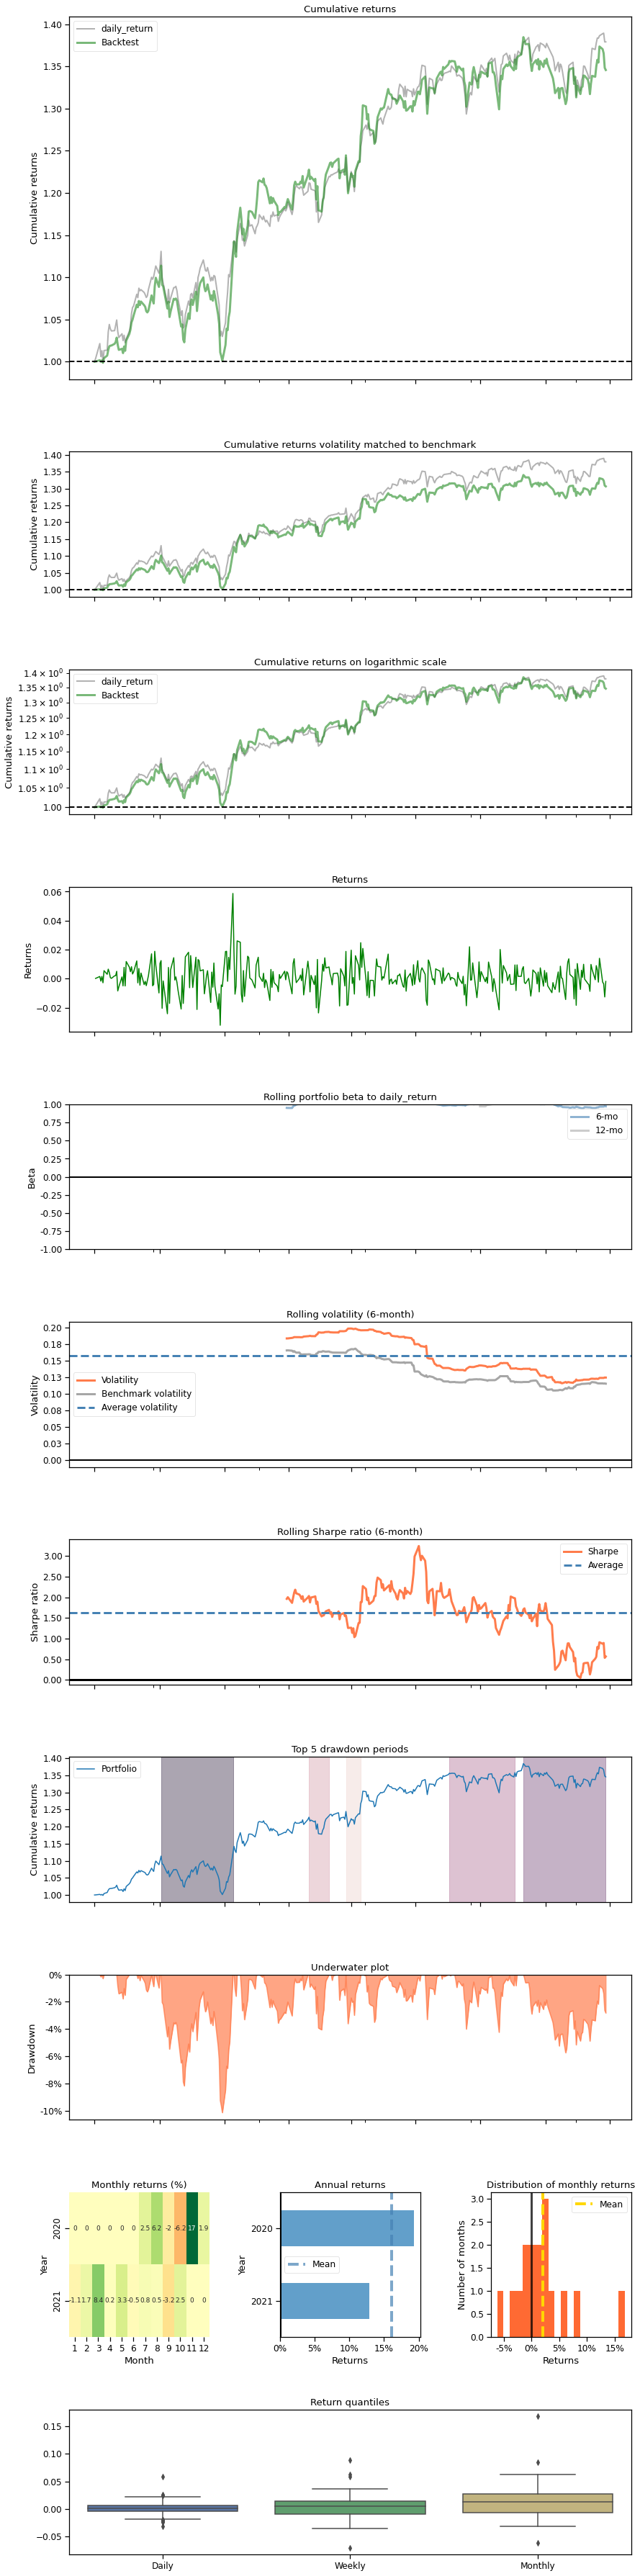

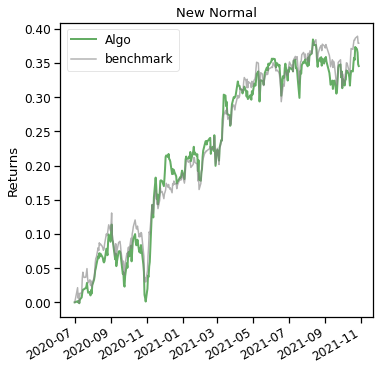

In [104]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value2)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'2.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value2.loc[0,'date'],
        end = df_account_value2.loc[len(df_account_value2)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value2, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value2.loc[0,'date'],
             baseline_end = df_account_value2.loc[len(df_account_value2)-1,'date'])